In [135]:
# pip install evidently

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from evidently import Report
from evidently.presets import DataDriftPreset
from evidently.presets import *

In [136]:
df=pd.read_csv("~/Downloads/Software_Salaries.csv")

In [58]:
# print(df.head())
print(df.tail())

                   job_title experience_level employment_type company_size  \
99995        DevOps Engineer              Mid       Full-time        Large   
99996             ML Enginer           Senior        Contract       Medium   
99997  Machine Learning Engr           Senior       Part-time       Medium   
99998     Research Scientist           Junior          Intern       Medium   
99999     Research Scientist              NaN             NaN        Large   

      company_location  remote_ratio salary_currency  years_experience  \
99995            India            50             EUR                14   
99996           Canada            50             USD                 4   
99997               UK            50             GBP                 2   
99998           Remote           100             CAD                14   
99999          Germany             0             CAD                 7   

         base_salary  bonus  stock_options   total_salary  salary_in_usd  \
99995   75

In [137]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Columns:\n", categorical_cols)
print("\nNumerical Columns:\n", numerical_cols)

Categorical Columns:
 ['job_title', 'experience_level', 'employment_type', 'company_size', 'company_location', 'salary_currency', 'currency']

Numerical Columns:
 ['remote_ratio', 'years_experience', 'base_salary', 'bonus', 'stock_options', 'total_salary', 'salary_in_usd', 'education', 'skills', 'conversion_rate', 'adjusted_total_usd']


In [60]:
# Categorical: unique values + count
print("\n--- CATEGORICAL COLUMN ANALYSIS ---\n")
for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    print(f"{col}:")
    print(f"  Unique Count: {df[col].nunique(dropna=True)}")
    print(f"  Unique Values: {unique_vals[:10]}{' ...' if len(unique_vals) > 10 else ''}\n")


--- CATEGORICAL COLUMN ANALYSIS ---

job_title:
  Unique Count: 12
  Unique Values: ['Data Analyst' 'DevOps Engineer' 'Research Scientist' 'Software Engr'
 'Dt Scientist' 'ML Enginer' 'Data Scienist' 'Data Scntist'
 'Machine Learning Engr' 'ML Engr'] ...

experience_level:
  Unique Count: 4
  Unique Values: ['Mid' 'Lead' 'Senior' 'Junior']

employment_type:
  Unique Count: 4
  Unique Values: ['Contract' 'Full-time' 'Intern' 'Part-time']

company_size:
  Unique Count: 3
  Unique Values: ['Medium' 'Small' 'Large']

company_location:
  Unique Count: 6
  Unique Values: ['Germany' 'India' 'UK' 'Canada' 'USA' 'Remote']

salary_currency:
  Unique Count: 5
  Unique Values: ['INR' 'GBP' 'EUR' 'CAD' 'USD']

currency:
  Unique Count: 5
  Unique Values: ['USD' 'EUR' 'INR' 'CAD' 'GBP']



There are multiple job_title which are same but having some difference in representation
experience_level, company_size is ordinal
rest are nominal

In [61]:
# Numerical: value ranges
print("\n--- NUMERICAL COLUMN ANALYSIS ---\n")
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}:")
    print(f"  Range: {min_val} to {max_val}\n")


--- NUMERICAL COLUMN ANALYSIS ---

remote_ratio:
  Range: 0 to 100

years_experience:
  Range: 0 to 20

base_salary:
  Range: -344.3371579687592 to 3121412.460786257

bonus:
  Range: 0 to 9999

stock_options:
  Range: 0 to 29998

total_salary:
  Range: 13732.47075427652 to 196335.83892646208

salary_in_usd:
  Range: 221.0069483671856 to 2354698.2352142474

education:
  Range: nan to nan

skills:
  Range: nan to nan

conversion_rate:
  Range: 0.012 to 1.3

adjusted_total_usd:
  Range: 164.78964905131826 to 4108339.899022134



In [35]:
# Checking for remote_ratio
print(df['remote_ratio'].unique())

[  0 100  50]


Remote_ratio is actually categorical column

In [138]:
# Data cleaning for categorical columns

# 1. Clean job_title values
job_title_mapping = {
    'Software Engr': 'Software Engineer',
    'Sofware Engneer': 'Software Engineer',
    'Softwre Engineer': 'Software Engineer',
    'Dt Scientist': 'Data Scientist',
    'Data Scienist': 'Data Scientist',
    'Data Scntist': 'Data Scientist',
    'ML Enginer': 'Machine Learning Engineer',
    'ML Engr': 'Machine Learning Engineer',
    'Machine Learning Engr': 'Machine Learning Engineer'
}
df['job_title'] = df['job_title'].replace(job_title_mapping)

# 2. Drop columns: 'education' and 'skills'
df=df.drop(['education', 'skills'], axis=1)

# 3. Convert remote_ratio to categorical
def map_remote_ratio(ratio):
    if ratio == 0:
        return 'On-site'
    elif ratio == 100:
        return 'Remote'
    else:
        return 'Hybrid'

df['remote_category'] = df['remote_ratio'].apply(map_remote_ratio)

# Optional: convert to categorical dtype
df['remote_category'] = df['remote_category'].astype('object')


# Confirm that no missing values remain
print("Missing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
job_title                 0
experience_level      20000
employment_type       23984
company_size              0
company_location          0
remote_ratio              0
salary_currency           0
years_experience          0
base_salary               0
bonus                     0
stock_options             0
total_salary              0
salary_in_usd             0
currency                  0
conversion_rate           0
adjusted_total_usd        0
remote_category           0
dtype: int64


In [139]:
# Data cleaning for numerical columns

# Count negative base_salary values (for reference)
neg_count = (df['base_salary'] < 0).sum()
print(f"Number of negative base_salary values: {neg_count}")

# Replace negative values with 0
df.loc[df['base_salary'] < 0, 'base_salary'] = 0

Number of negative base_salary values: 4


In [140]:
# Step 1: Remove 'remote_ratio' from numerical columns
if 'remote_ratio' in numerical_cols:
    numerical_cols.remove('remote_ratio')

# Step 2: Add 'remote_category' to categorical columns (if not already included)
if 'remote_ratio' not in categorical_cols:
    categorical_cols.append('remote_ratio')

# Optional: show updated lists
print("Updated Numerical Columns:\n", numerical_cols)
print("\nUpdated Categorical Columns:\n", categorical_cols)

Updated Numerical Columns:
 ['years_experience', 'base_salary', 'bonus', 'stock_options', 'total_salary', 'salary_in_usd', 'education', 'skills', 'conversion_rate', 'adjusted_total_usd']

Updated Categorical Columns:
 ['job_title', 'experience_level', 'employment_type', 'company_size', 'company_location', 'salary_currency', 'currency', 'remote_ratio']


In [99]:
# Original DataFrame copy (before imputing or dropping)
df_base = df.copy()

# Mode values for imputation
exp_mode = df_base['experience_level'].mode()[0]
emp_mode = df_base['employment_type'].mode()[0]

# 1. Imputed dataset
df_imputed = df_base.copy()
df_imputed['experience_level'] = df_imputed['experience_level'].fillna(exp_mode)
df_imputed['employment_type'] = df_imputed['employment_type'].fillna(emp_mode)

# 2. Dropped rows dataset
df_dropped = df_base.dropna(subset=['experience_level', 'employment_type'])

# Optional sanity check
print("Original shape:", df.shape)
print("After imputation:", df_imputed.shape)
print("After dropping rows:", df_dropped.shape)

# Create the report
# report = Report(metrics=[DataDriftPreset()])

# Run the comparison — DO NOT assign to a variable

report.run(reference_data=df_dropped, current_data=df_imputed)
# from evidently.report import Report
# from evidently.metric_preset import DataDriftPreset
from IPython.display import IFrame
import os


# Initialize and run the report
report = Report(metrics=[DataDriftPreset()])
rep=report.run(reference_data=df_dropped, current_data=df_imputed)

# Save as HTML, JSON, and dict
rep.save_html("data_drift_report.html")
rep.save_json("data_drift_report.json")

# Display inline in Jupyter or other notebook
IFrame(src="data_drift_report.html", width=1000, height=600)

Original shape: (100000, 17)
After imputation: (100000, 17)
After dropping rows: (76016, 17)


We can observe that removing the missing values rows and imputing the missing values both are having data drift, so we can't just pick any these to handle missing values, now we have to understand if the data is missing at random or not at random.

In [100]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

def check_missingness_mcar(df, col_with_missing, categorical_cols, numerical_cols):
    print(f"\n=== Checking missingness for '{col_with_missing}' ===")

    # Create binary indicator: 1 = missing, 0 = not missing
    df['missing_flag'] = df[col_with_missing].isnull().astype(int)

    # Separate data into missing and not missing groups
    missing_group = df[df['missing_flag'] == 1]
    non_missing_group = df[df['missing_flag'] == 0]

    print(f"Missing count: {missing_group.shape[0]}, Non-missing count: {non_missing_group.shape[0]}")

    # 1. Check correlation of missingness with numerical features
    print("\nCorrelation of missingness with numerical columns:")
    corr = df[numerical_cols + ['missing_flag']].corr()['missing_flag'].drop('missing_flag')
    print(corr)

    # 2. Compare distributions for numerical variables (Mann-Whitney U test)
    print("\nNumerical feature distribution difference tests:")
    for col in numerical_cols:
        if df[col].isnull().all():
            # Skip if entire column is null
            continue
        group1 = missing_group[col].dropna()
        group2 = non_missing_group[col].dropna()
        if len(group1) < 5 or len(group2) < 5:
            print(f"  {col}: Not enough data to test")
            continue
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        print(f"  {col}: Mann-Whitney U test p-value = {p:.4f} {'(Possible difference)' if p < 0.05 else '(No difference)'}")

    # 3. Compare distributions for categorical variables (Chi-square test)
    print("\nCategorical feature distribution difference tests:")
    for col in categorical_cols:
        if col == col_with_missing:
            continue  # skip self
        contingency_table = pd.crosstab(df['missing_flag'], df[col])
        if contingency_table.shape[1] < 2:
            print(f"  {col}: Not enough categories to test")
            continue
        stat, p, dof, expected = chi2_contingency(contingency_table)
        print(f"  {col}: Chi-square test p-value = {p:.4f} {'(Possible difference)' if p < 0.05 else '(No difference)'}")

    # Drop the helper column
    df.drop(columns=['missing_flag'], inplace=True)

# Example usage:

categorical_cols = ['job_title', 'employment_type', 'experience_level', 'company_size', 
                    'company_location', 'salary_currency', 'currency', 'remote_category']

numerical_cols = ['years_experience', 'base_salary', 'bonus', 'stock_options', 'total_salary', 
                  'salary_in_usd', 'conversion_rate', 'adjusted_total_usd']

# Check for 'experience_level'
check_missingness_mcar(df, 'experience_level', categorical_cols, numerical_cols)

# Check for 'employment_type'
check_missingness_mcar(df, 'employment_type', categorical_cols, numerical_cols)



=== Checking missingness for 'experience_level' ===
Missing count: 20000, Non-missing count: 80000

Correlation of missingness with numerical columns:
years_experience     -0.003366
base_salary           0.619025
bonus                -0.000977
stock_options         0.000760
total_salary          0.000450
salary_in_usd         0.002662
conversion_rate       0.001334
adjusted_total_usd    0.532151
Name: missing_flag, dtype: float64

Numerical feature distribution difference tests:
  years_experience: Mann-Whitney U test p-value = 0.2877 (No difference)
  base_salary: Mann-Whitney U test p-value = 0.0000 (Possible difference)
  bonus: Mann-Whitney U test p-value = 0.7604 (No difference)
  stock_options: Mann-Whitney U test p-value = 0.8155 (No difference)
  total_salary: Mann-Whitney U test p-value = 0.8316 (No difference)
  salary_in_usd: Mann-Whitney U test p-value = 0.9879 (No difference)
  conversion_rate: Mann-Whitney U test p-value = 0.6626 (No difference)
  adjusted_total_usd: Man

The missing values in experience_level and employment_type are not Missing Completely At Random (MCAR). Statistical tests show that missingness correlates significantly with features like base_salary, job_title, and company_size. Hence, simple row removal or mode imputation would bias the dataset and cause data drift. A model-based imputation approach is recommended to predict and fill these missing values based on other related features, improving data quality and reducing bias.

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def model_based_imputation(df, target_col, feature_cols):
    df_copy = df.copy()

    # Encode categorical features & target if needed
    le_target = LabelEncoder()
    df_copy[target_col+'_encoded'] = le_target.fit_transform(df_copy[target_col].astype(str))

    # Split data into known and missing
    known = df_copy[df_copy[target_col].notnull()]
    missing = df_copy[df_copy[target_col].isnull()]

    if missing.empty:
        print(f"No missing values in {target_col} to impute.")
        return df_copy

    # Features and target for training
    X_train = known[feature_cols]
    y_train = known[target_col]

    # Features for missing data
    X_missing = missing[feature_cols]

    # Encode categorical features in X (simple encoding for demonstration)
    X_all = pd.concat([X_train, X_missing])
    X_all_encoded = pd.get_dummies(X_all, drop_first=True)
    X_train_enc = X_all_encoded.loc[X_train.index]
    X_missing_enc = X_all_encoded.loc[X_missing.index]

    # Train classifier
    clf = RandomForestClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train_enc, y_train)

    # Predict missing values
    pred_missing = clf.predict(X_missing_enc)

    # Impute predicted values back to original dataframe
    df_copy.loc[missing.index, target_col] = pred_missing

    return df_copy

# Columns to use as features (choose carefully; exclude target and columns with missing data)
feature_columns = ['job_title', 'company_size', 'remote_ratio', 'base_salary', 'years_experience']

# Impute experience_level
df_imputed_exp = model_based_imputation(df, 'experience_level', feature_columns)

# Impute employment_type
df_imputed_emp = model_based_imputation(df_imputed_exp, 'employment_type', feature_columns)

# Now df_imputed_emp has both columns imputed with predicted values
df=df_imputed_emp.copy()

In [72]:
# Univariant analysis


--- job_title ---
Unique values count: 6
Top 10 value counts:
job_title
Software Engineer            16951
Data Analyst                 16857
DevOps Engineer              16764
Data Scientist               16637
Research Scientist           16552
Machine Learning Engineer    16239
Name: count, dtype: int64


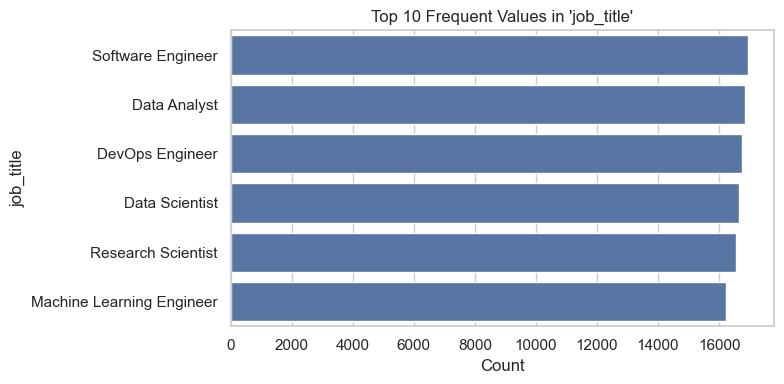


--- employment_type ---
Unique values count: 4
Top 10 value counts:
employment_type
Intern       26538
Full-time    25095
Part-time    24337
Contract     24030
Name: count, dtype: int64


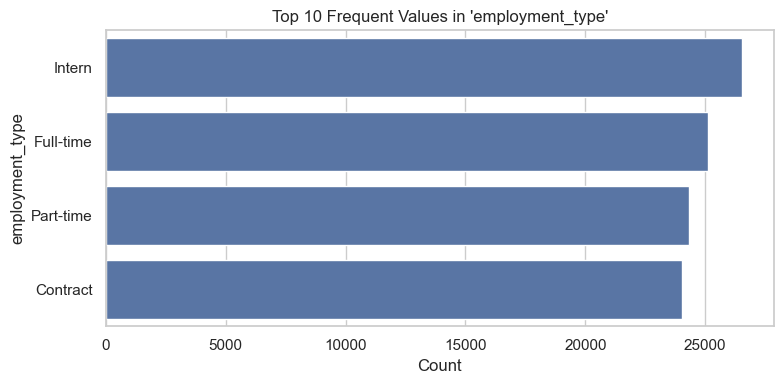


--- experience_level ---
Unique values count: 4
Top 10 value counts:
experience_level
Lead      32513
Mid       22548
Senior    22482
Junior    22457
Name: count, dtype: int64


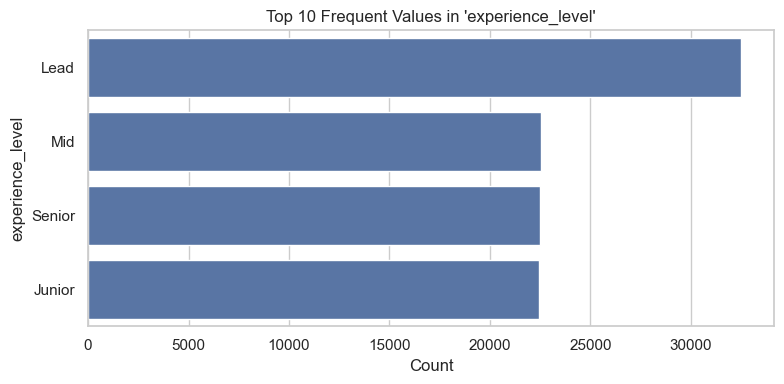


--- company_size ---
Unique values count: 3
Top 10 value counts:
company_size
Small     33538
Medium    33469
Large     32993
Name: count, dtype: int64


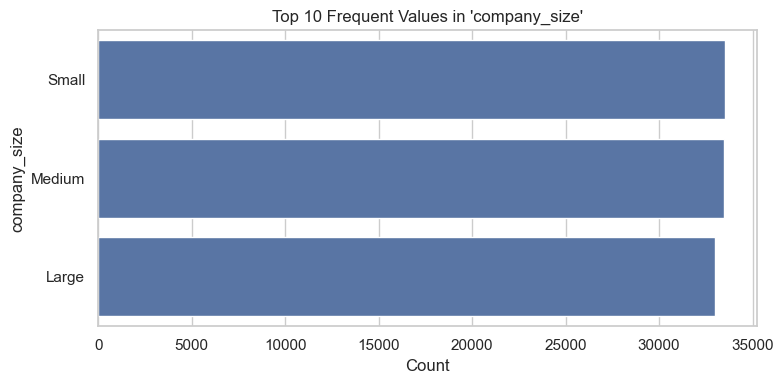


--- company_location ---
Unique values count: 6
Top 10 value counts:
company_location
UK         17087
Remote     16704
USA        16630
Canada     16558
India      16511
Germany    16510
Name: count, dtype: int64


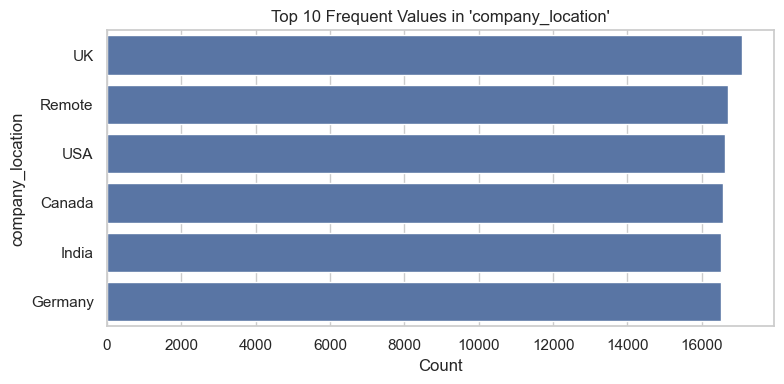


--- salary_currency ---
Unique values count: 5
Top 10 value counts:
salary_currency
GBP    20197
USD    20100
EUR    20006
INR    19864
CAD    19833
Name: count, dtype: int64


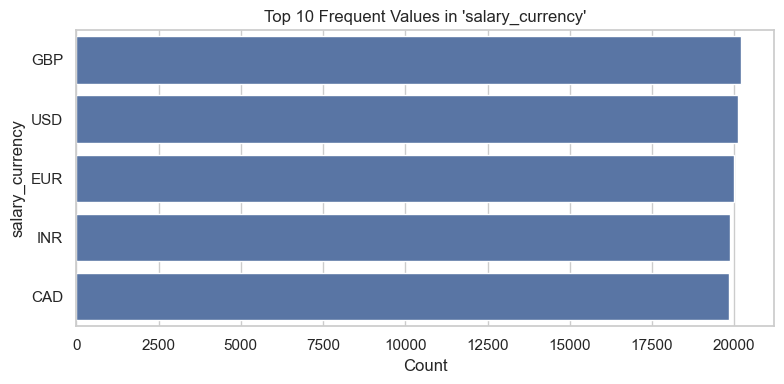


--- currency ---
Unique values count: 5
Top 10 value counts:
currency
GBP    20202
USD    20084
CAD    20008
INR    19934
EUR    19772
Name: count, dtype: int64


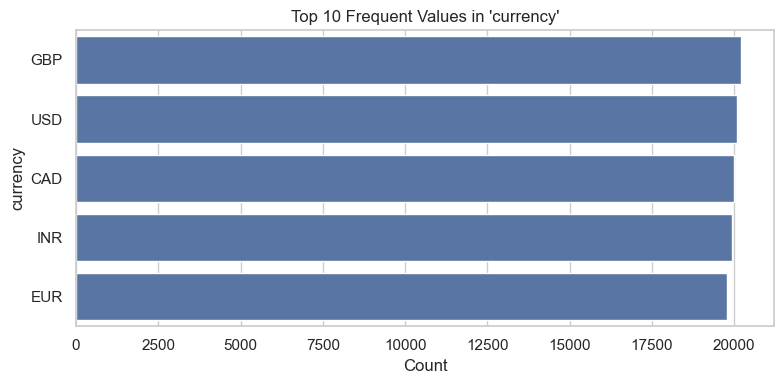


--- remote_category ---
Unique values count: 3
Top 10 value counts:
remote_category
Hybrid     33652
On-site    33274
Remote     33074
Name: count, dtype: int64


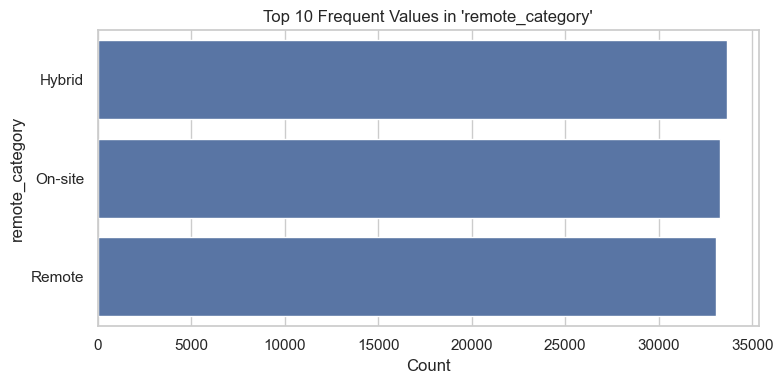

In [108]:
# For categorical columns

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Loop through each categorical column
for col in categorical_cols:
    print(f"\n--- {col} ---")
    
    # Number of unique values
    unique_vals = df[col].nunique()
    print(f"Unique values count: {unique_vals}")
    
    # Top 10 most frequent values
    print("Top 10 value counts:")
    print(df[col].value_counts().head(10))
    
    # Plot bar chart
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10])
    plt.title(f"Top 10 Frequent Values in '{col}'")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



--- years_experience ---
count    100000.000000
mean         10.010730
std           6.058082
min           0.000000
25%           5.000000
50%          10.000000
75%          15.000000
max          20.000000
Name: years_experience, dtype: float64
Range: 0 to 20


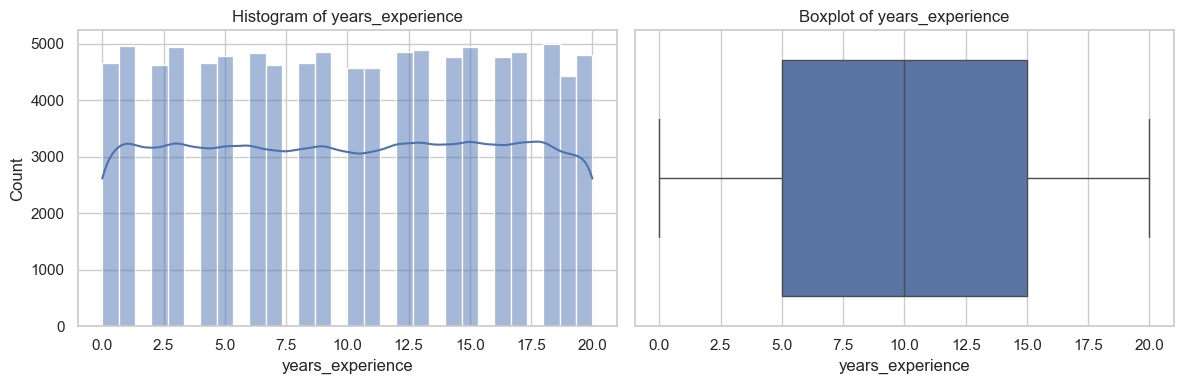


--- base_salary ---
count    1.000000e+05
mean     2.739155e+05
std      6.098245e+05
min      0.000000e+00
25%      5.913957e+04
50%      9.292292e+04
75%      1.260539e+05
max      3.121412e+06
Name: base_salary, dtype: float64
Range: 0.0 to 3121412.460786257


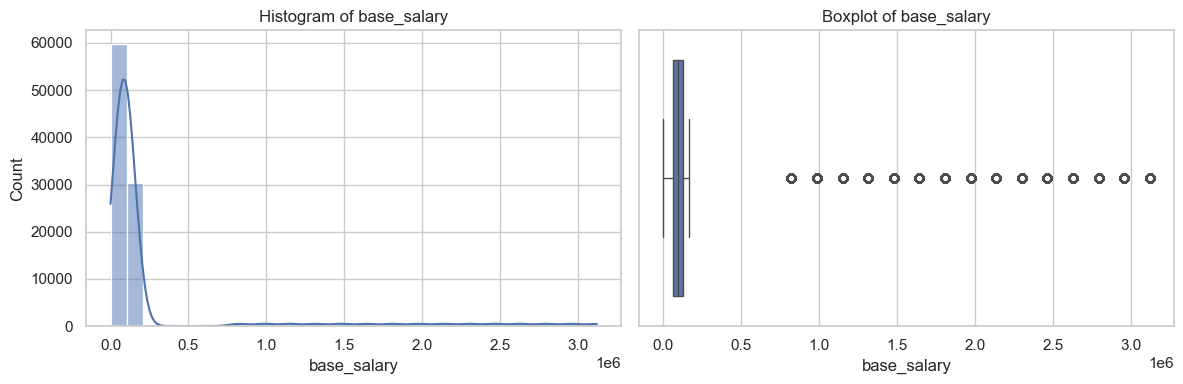


--- bonus ---
count    100000.000000
mean       5000.533550
std        2891.501293
min           0.000000
25%        2508.000000
50%        5004.000000
75%        7504.250000
max        9999.000000
Name: bonus, dtype: float64
Range: 0 to 9999


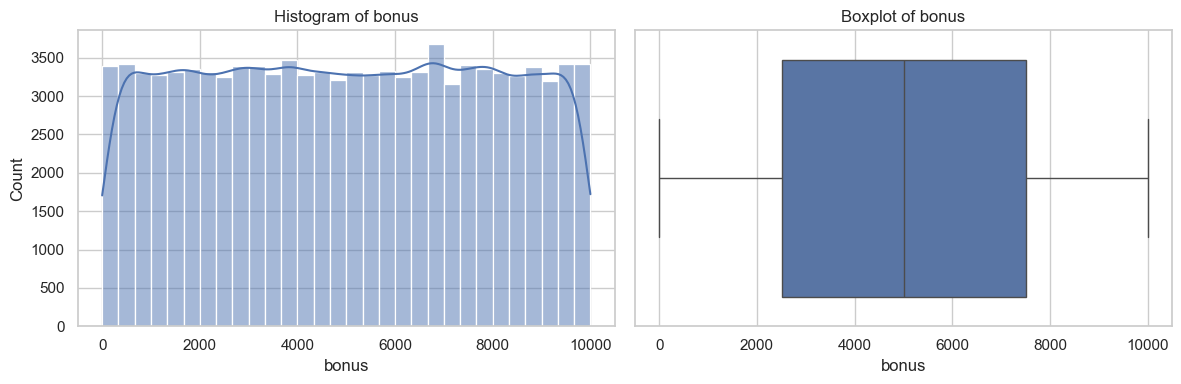


--- stock_options ---
count    100000.000000
mean      15014.530770
std        8664.142702
min           0.000000
25%        7463.750000
50%       14995.000000
75%       22530.000000
max       29998.000000
Name: stock_options, dtype: float64
Range: 0 to 29998


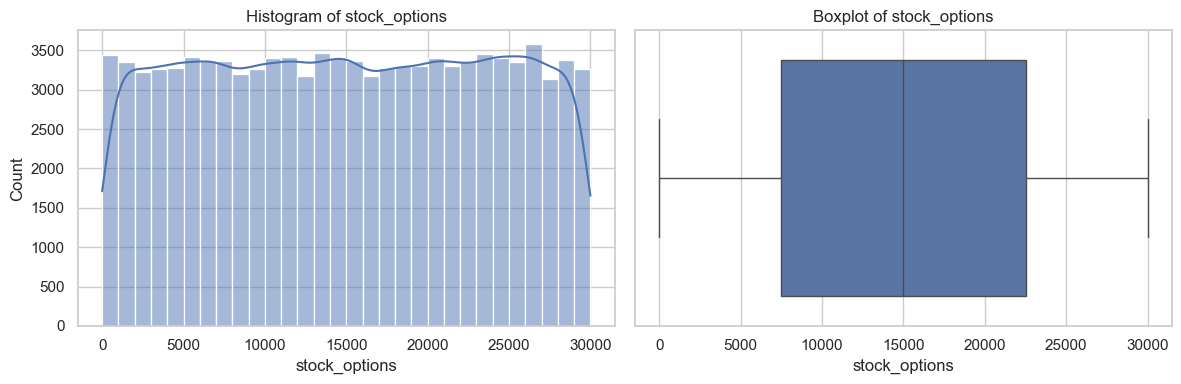


--- total_salary ---
count    100000.000000
mean     105189.402427
std       36335.187042
min       13732.470754
25%       74890.960608
50%      105372.474677
75%      135233.162454
max      196335.838926
Name: total_salary, dtype: float64
Range: 13732.47075427652 to 196335.83892646208


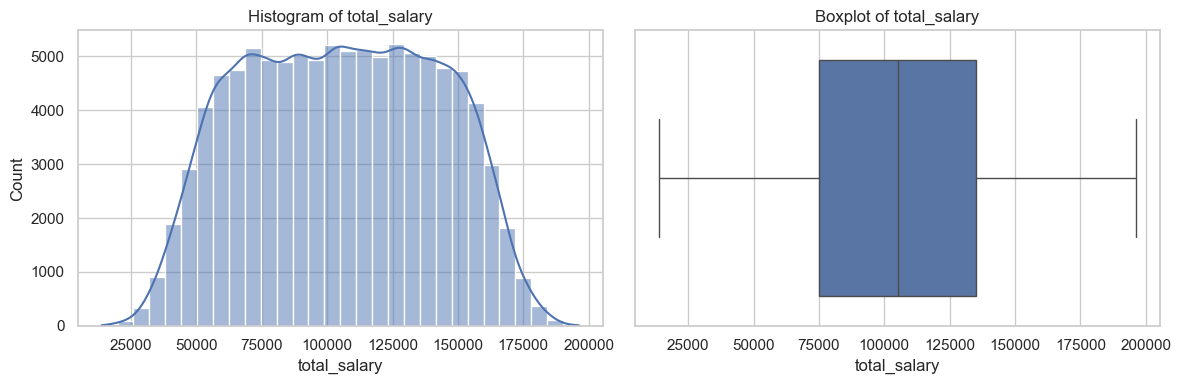


--- salary_in_usd ---
count    1.000000e+05
mean     1.033400e+05
std      1.461287e+05
min      2.210069e+02
25%      4.833807e+04
50%      9.129188e+04
75%      1.333567e+05
max      2.354698e+06
Name: salary_in_usd, dtype: float64
Range: 221.0069483671856 to 2354698.2352142474


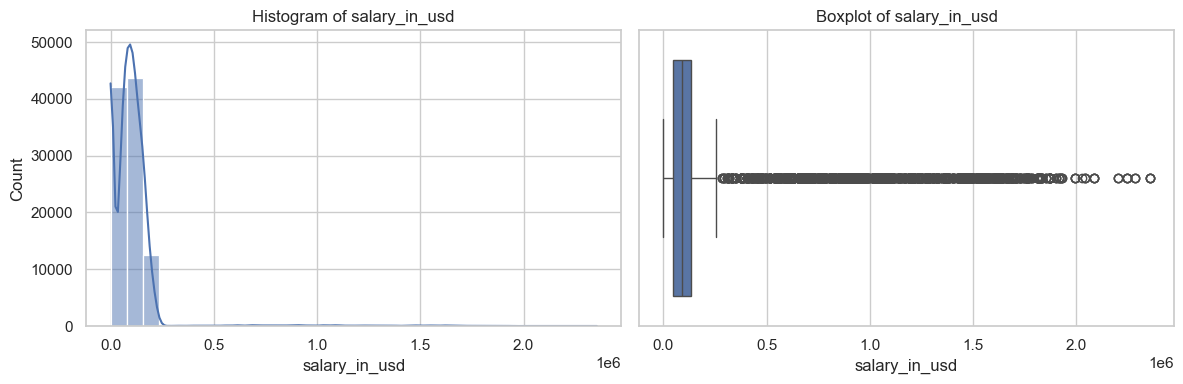


--- conversion_rate ---
count    100000.000000
mean          0.833410
std           0.446652
min           0.012000
25%           0.750000
50%           1.000000
75%           1.100000
max           1.300000
Name: conversion_rate, dtype: float64
Range: 0.012 to 1.3


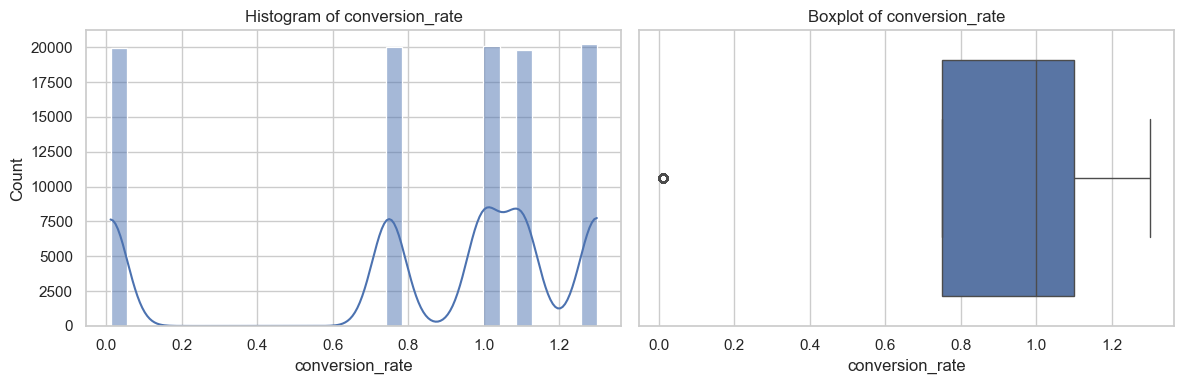


--- adjusted_total_usd ---
count    1.000000e+05
mean     2.451668e+05
std      5.918202e+05
min      1.647896e+02
25%      4.949571e+04
50%      9.518815e+04
75%      1.430316e+05
max      4.108340e+06
Name: adjusted_total_usd, dtype: float64
Range: 164.78964905131826 to 4108339.899022134


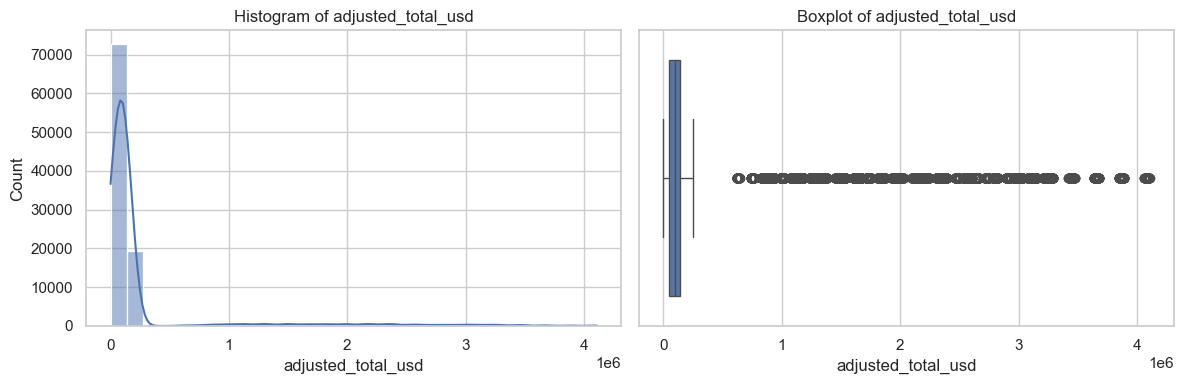

In [110]:
# For numerical columns

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for col in numerical_cols:
    print(f"\n--- {col} ---")
    
    # Basic stats
    print(df[col].describe())
    
    # Range
    col_min = df[col].min()
    col_max = df[col].max()
    print(f"Range: {col_min} to {col_max}")
    
    # Plot histogram + boxplot side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(df[col], bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram of {col}")
    
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()


We can clearly notice outliers in some columns, also they are all right skewed

base_salary skewness: 3.26


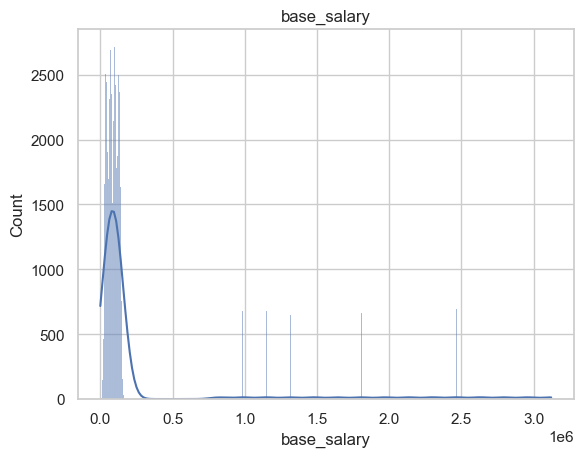

salary_in_usd skewness: 7.40


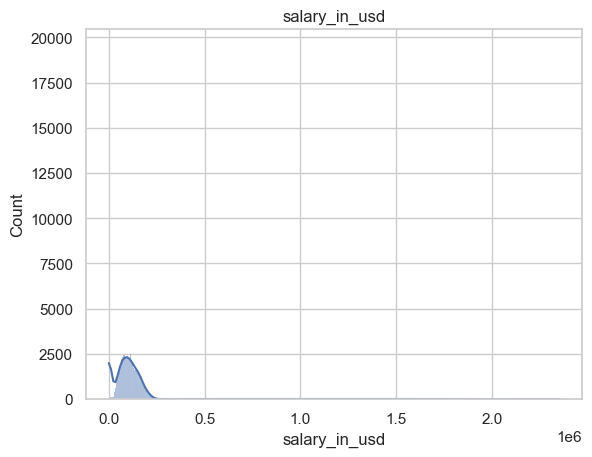

adjusted_total_usd skewness: 3.91


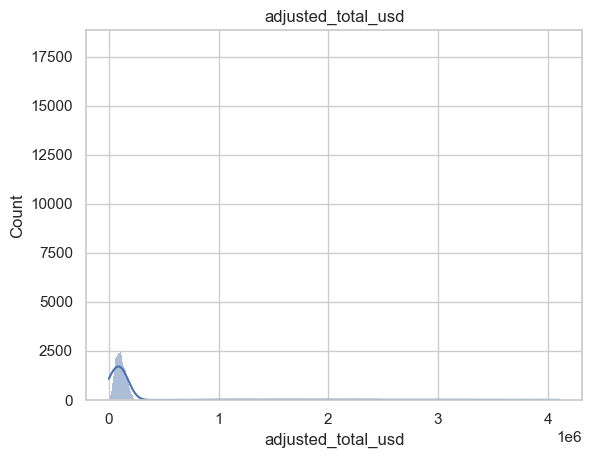

In [112]:
from scipy.stats import skew

for col in ['base_salary', 'salary_in_usd', 'adjusted_total_usd']:
    print(f"{col} skewness: {df[col].skew():.2f}")
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

In [142]:
# Handling the outliers and removing skewness

import numpy as np

def winsorize_column(df, col, lower=0.01, upper=0.99):
    lower_bound = df[col].quantile(lower)
    upper_bound = df[col].quantile(upper)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

for col in ['base_salary', 'salary_in_usd', 'adjusted_total_usd']:
    df = winsorize_column(df, col)

for col in ['base_salary', 'salary_in_usd', 'adjusted_total_usd']:
    df[f'log_{col}'] = np.log1p(df[col])  # log1p handles 0s safely

log_base_salary skewness: 1.81


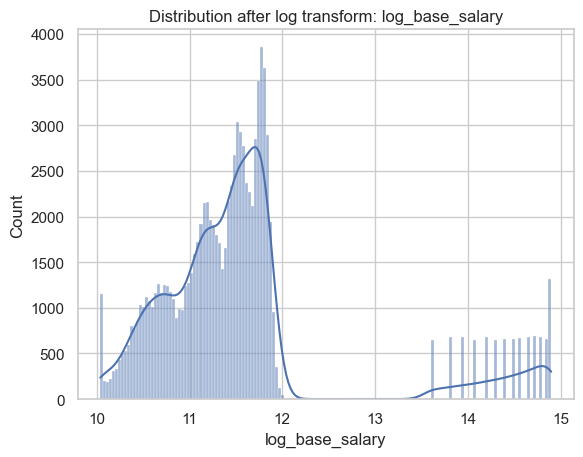

log_salary_in_usd skewness: -1.31


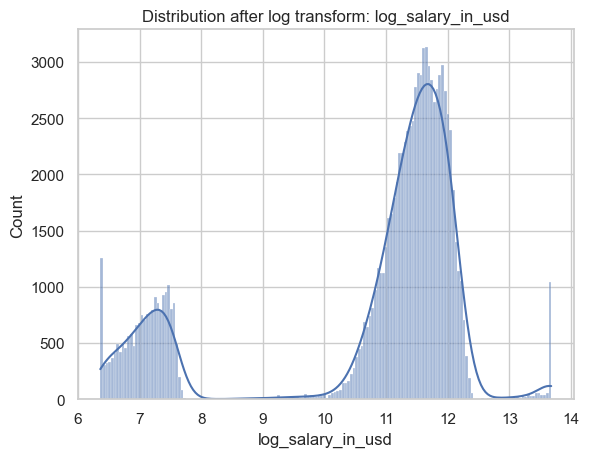

log_adjusted_total_usd skewness: -0.79


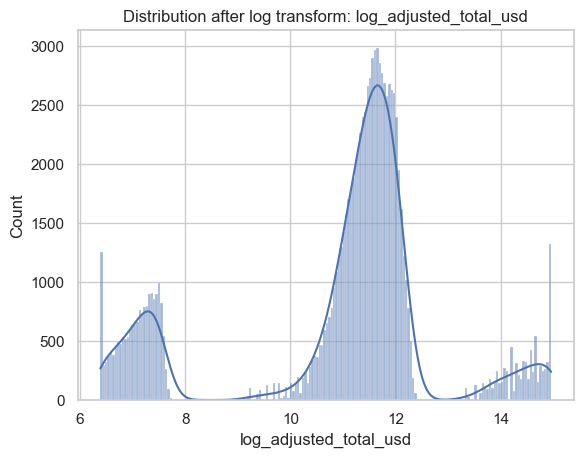

In [143]:
for col in ['log_base_salary', 'log_salary_in_usd', 'log_adjusted_total_usd']:
    print(f"{col} skewness: {df[col].skew():.2f}")
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution after log transform: {col}')
    plt.show()

Bivariant Analysis

Updated Numerical Columns:
 ['years_experience', 'base_salary', 'bonus', 'stock_options', 'total_salary', 'salary_in_usd', 'conversion_rate', 'adjusted_total_usd']

Step 1: Categorical vs Numerical

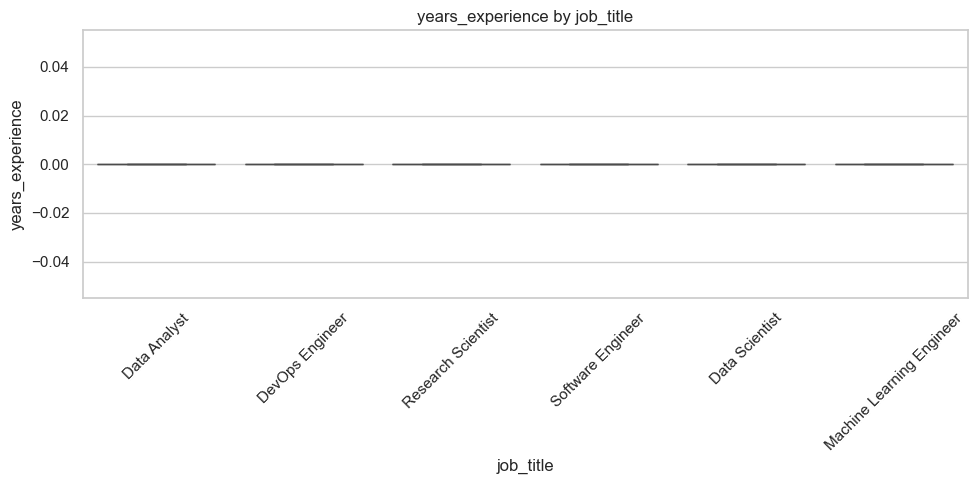

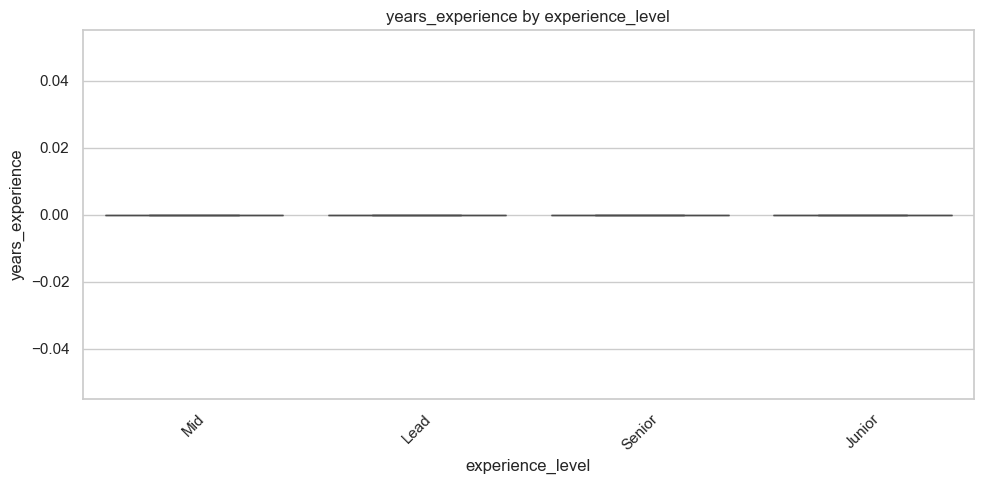

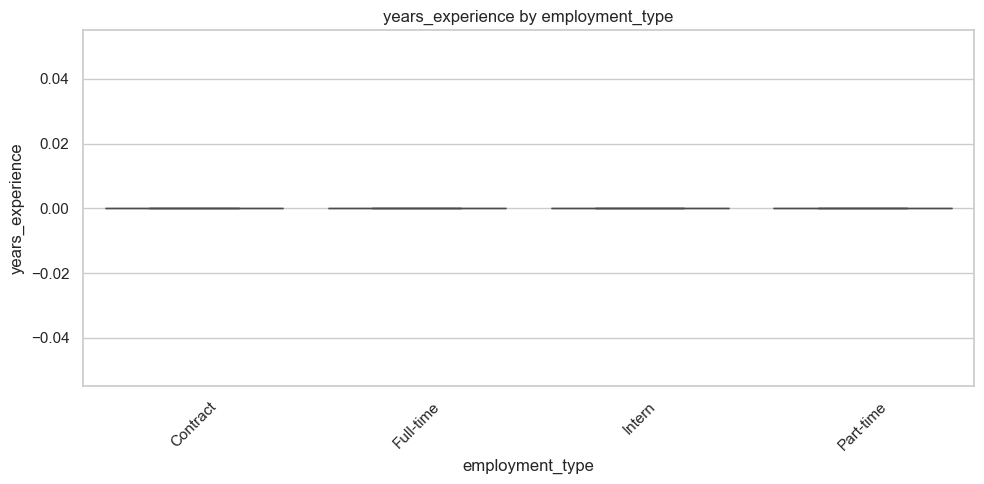

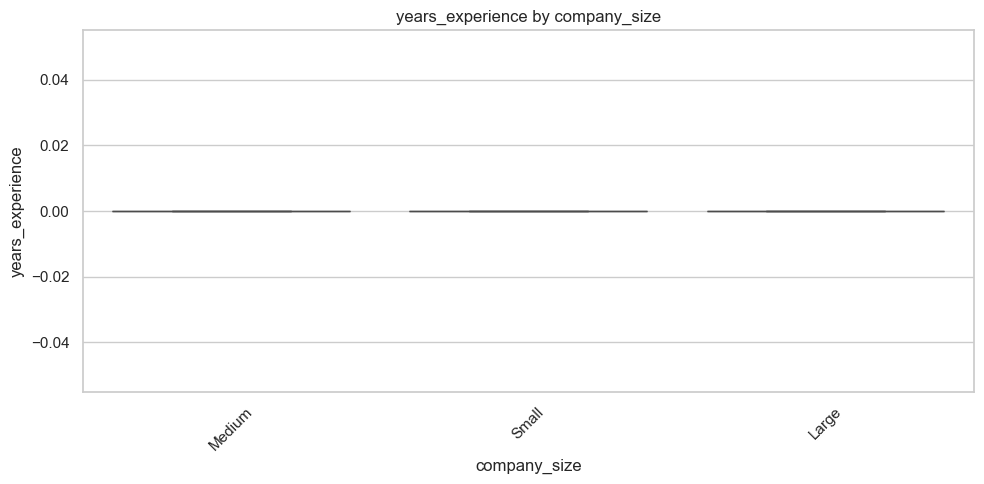

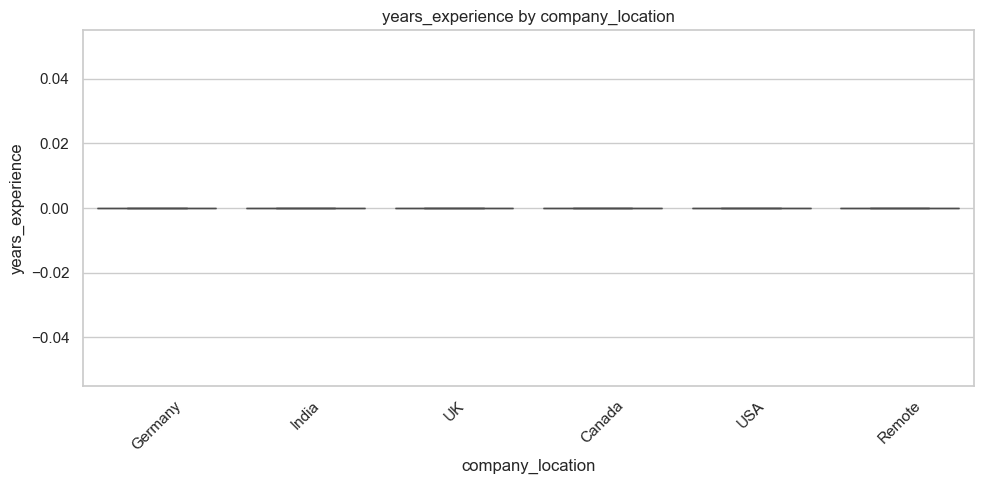

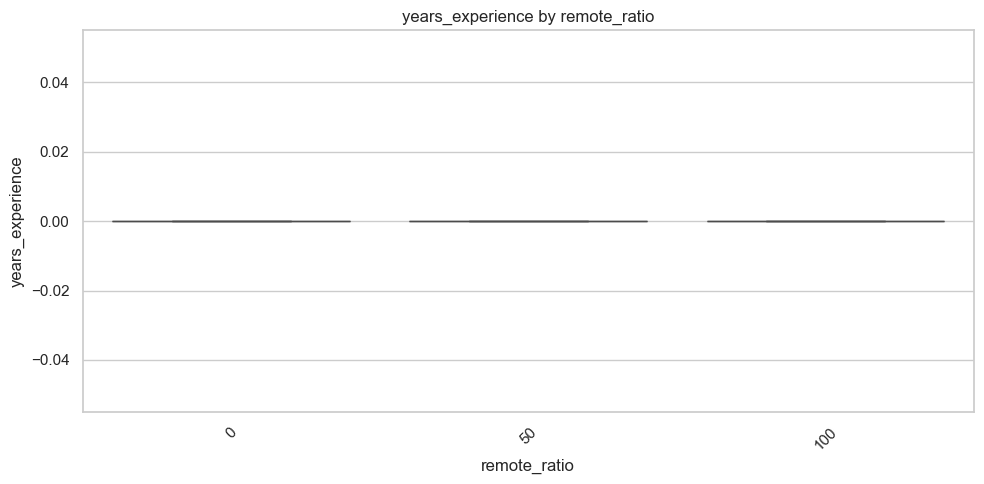

In [133]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'years_experience'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


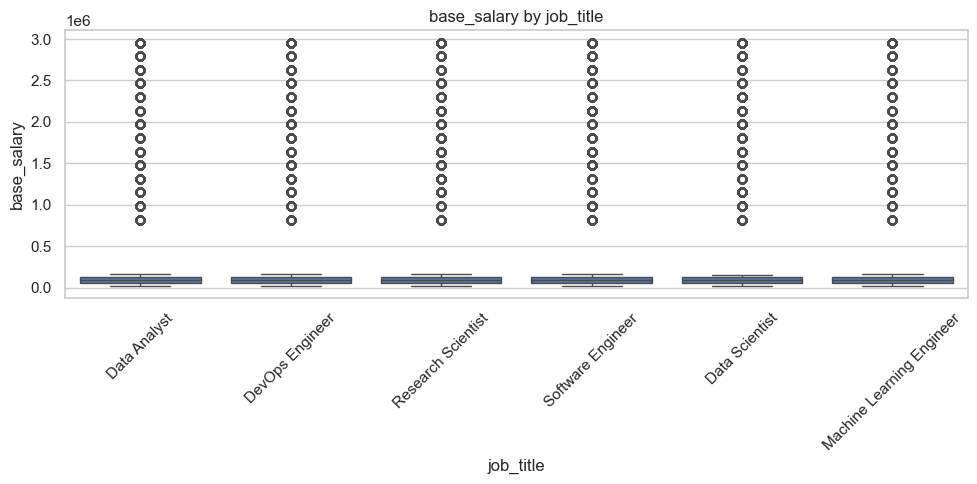

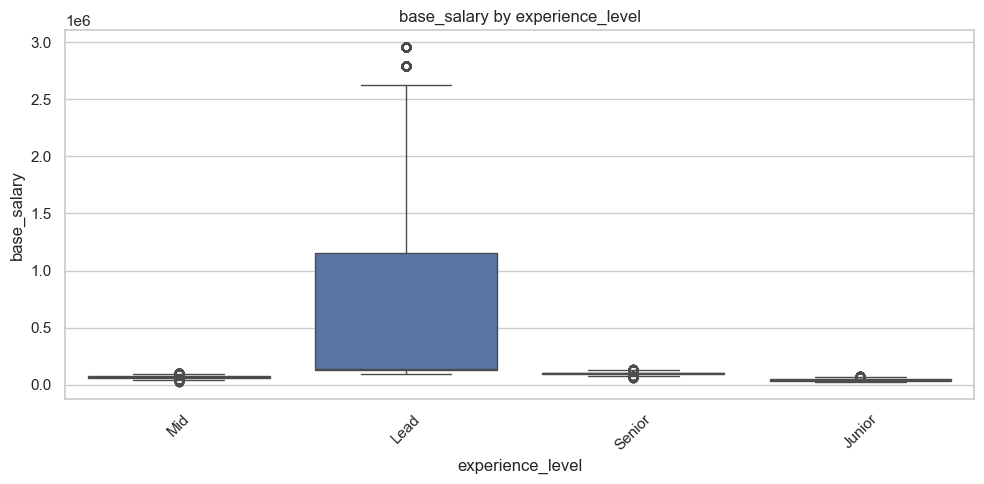

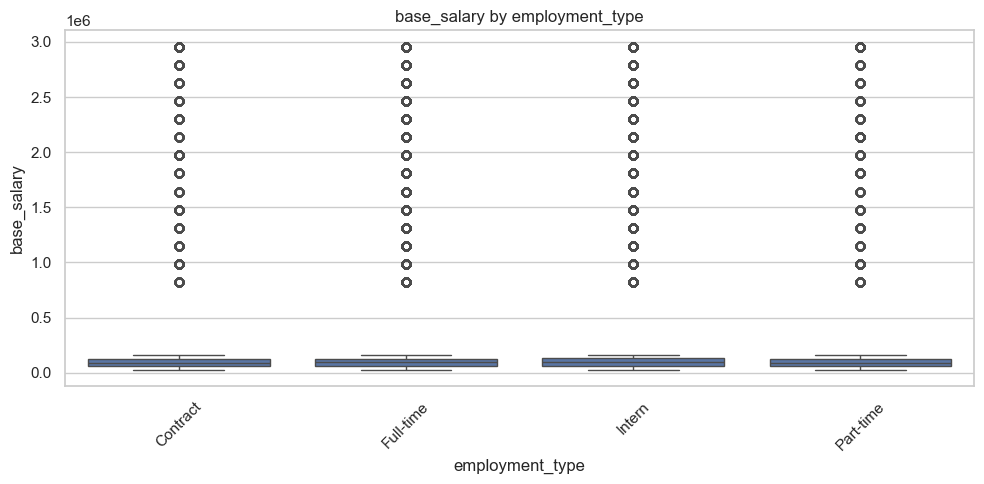

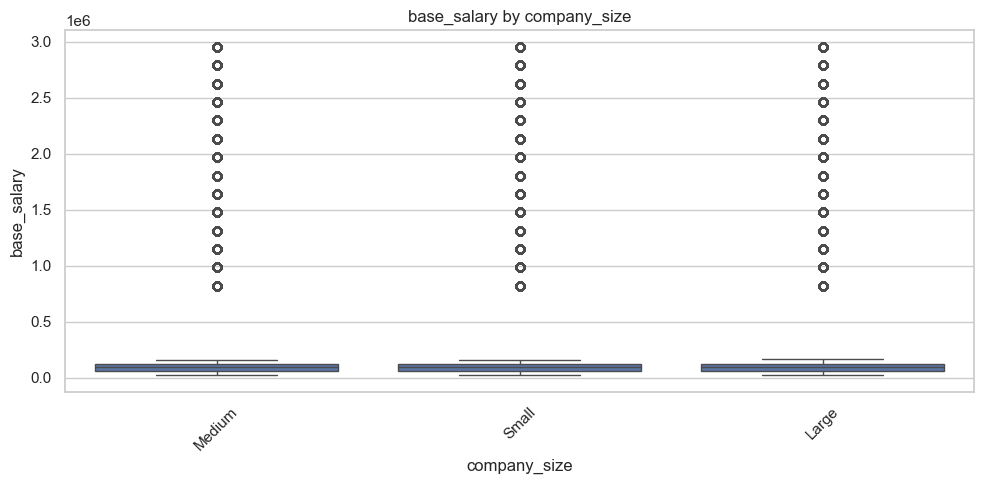

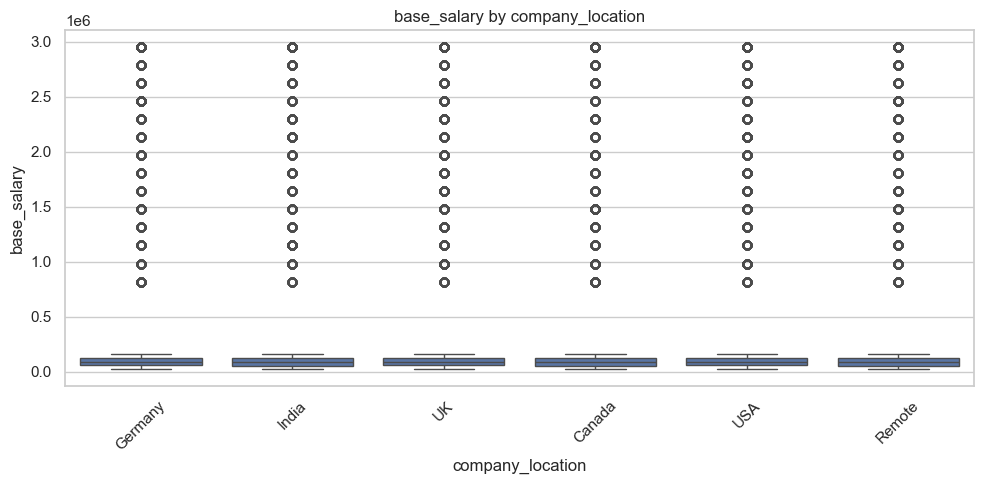

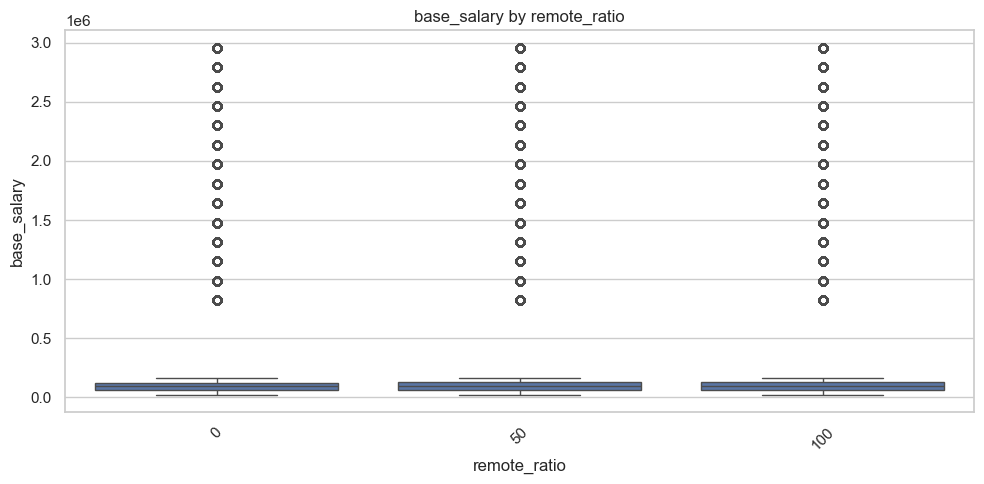

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

target = 'base_salary'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


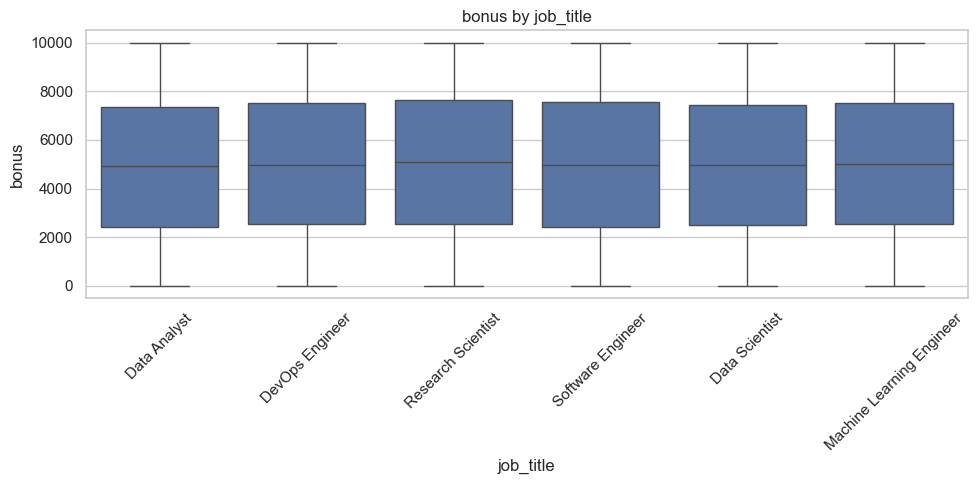

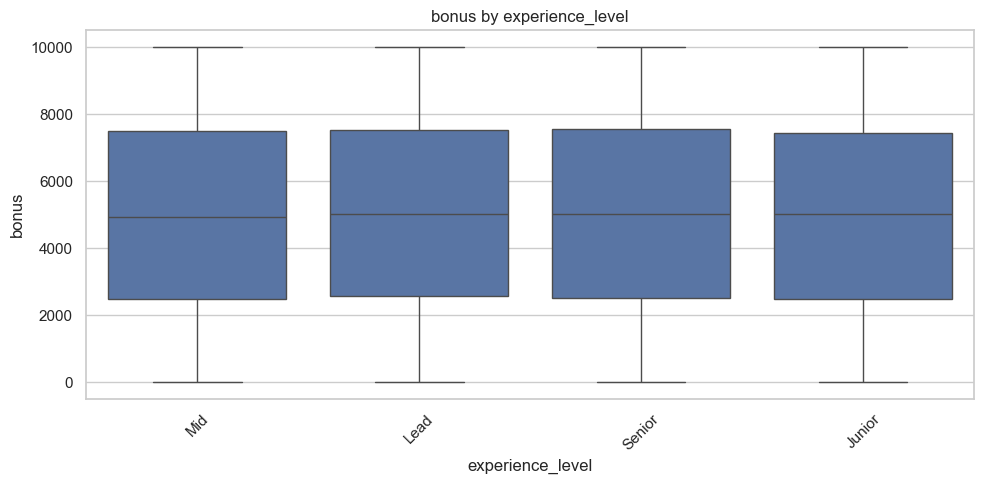

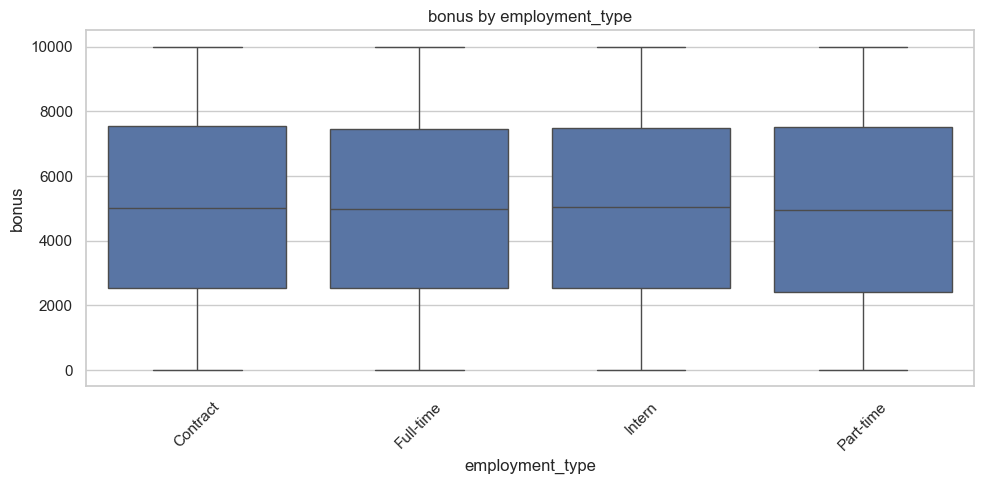

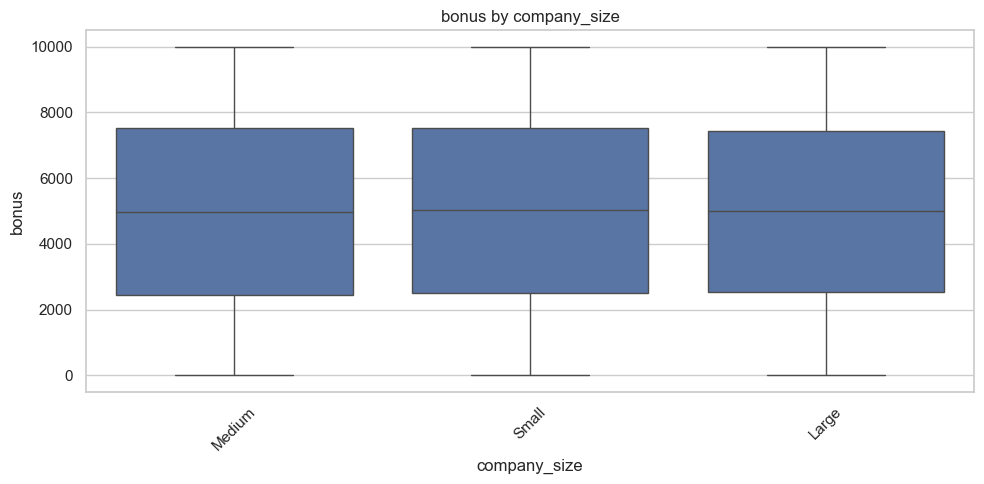

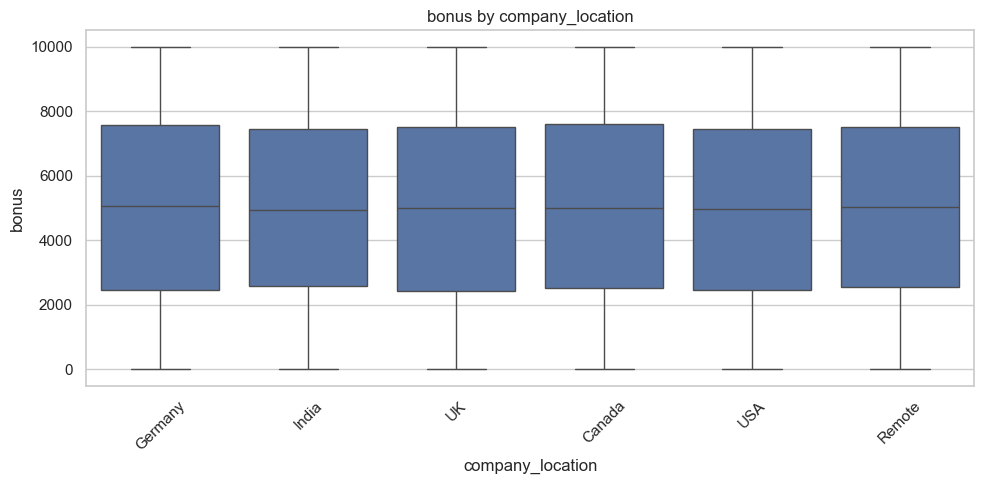

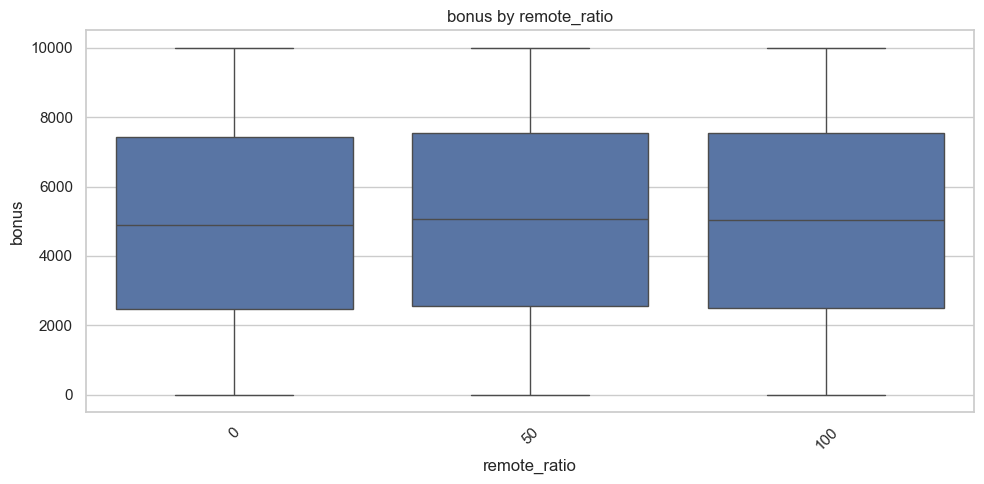

In [125]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'bonus'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


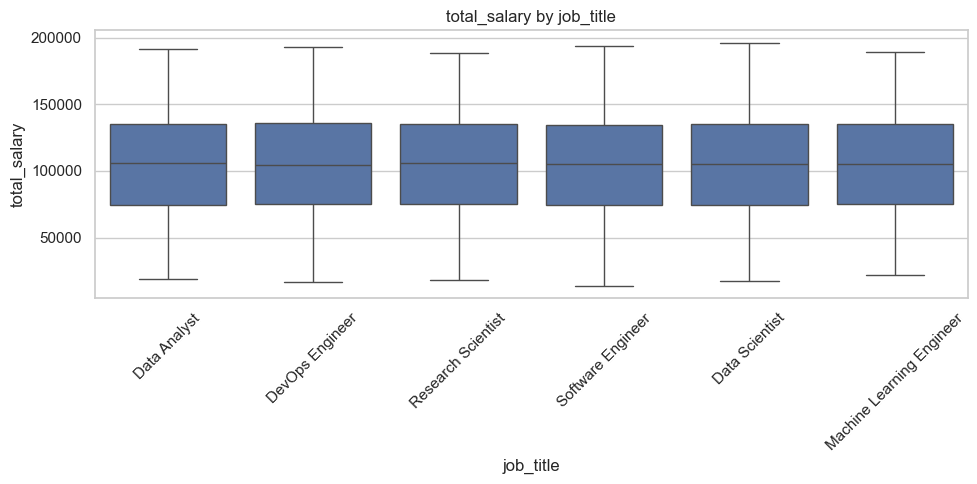

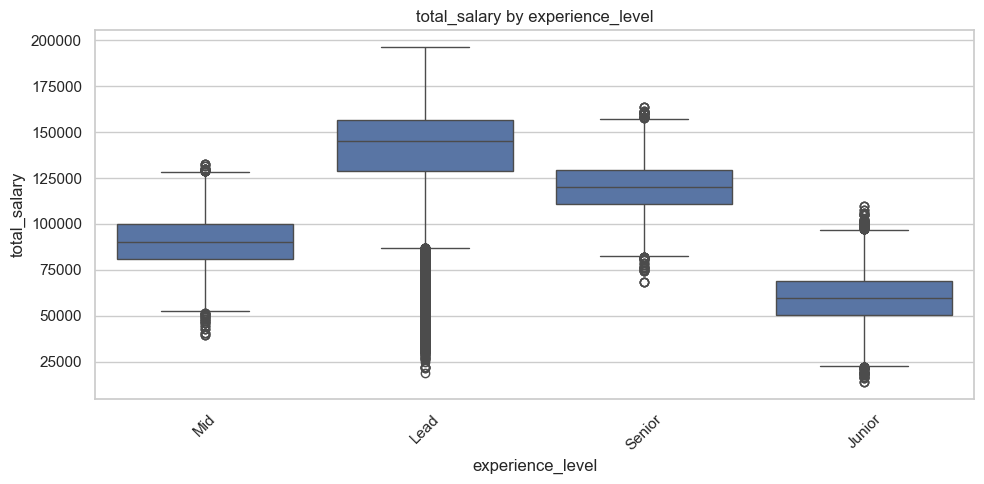

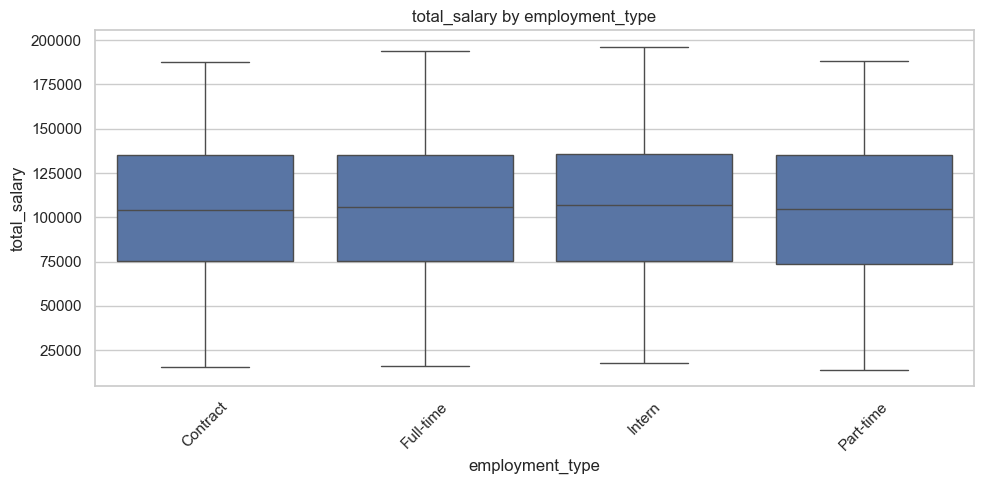

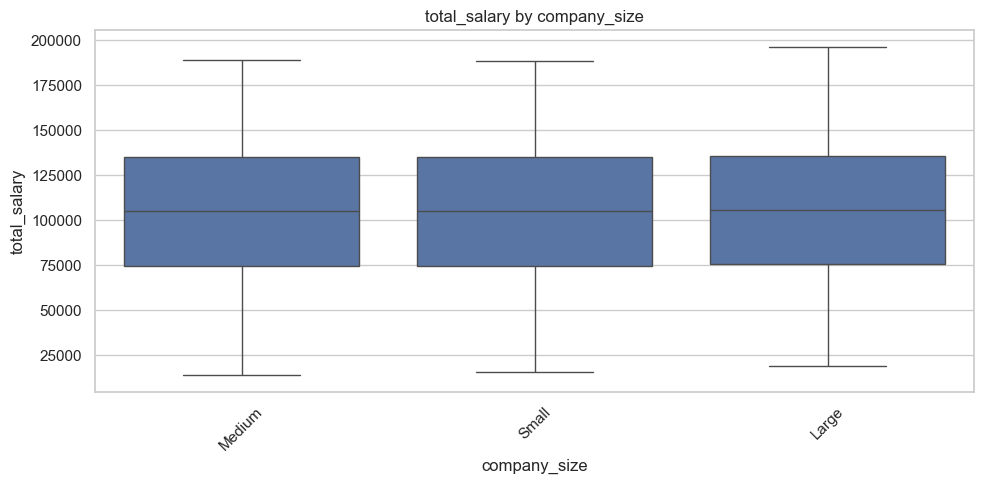

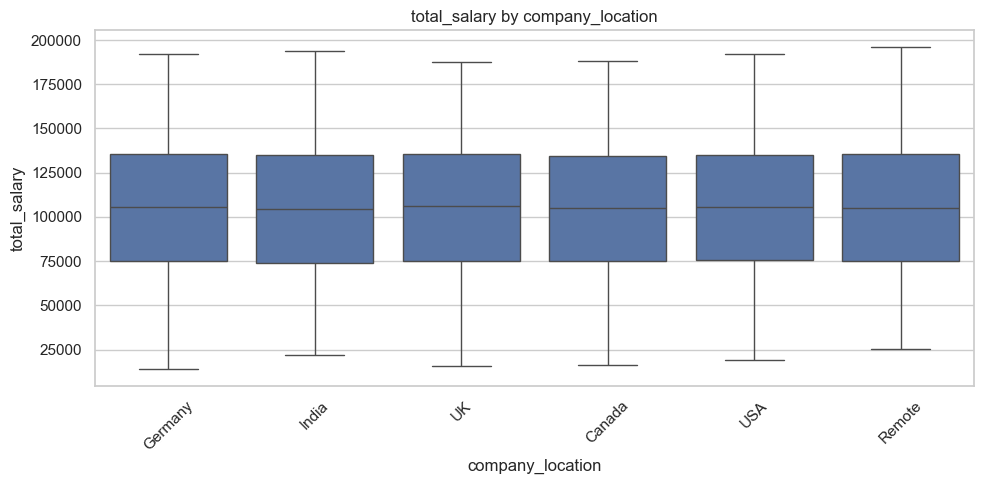

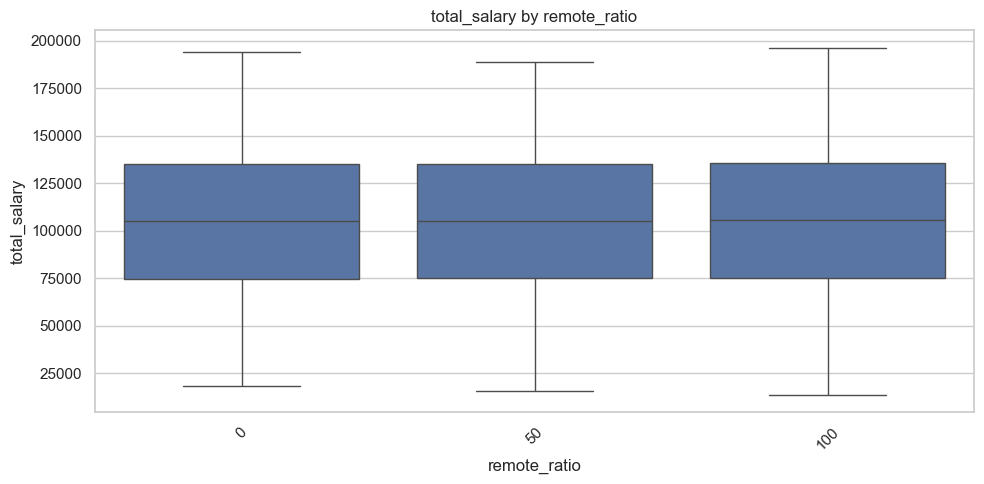

In [126]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'total_salary'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


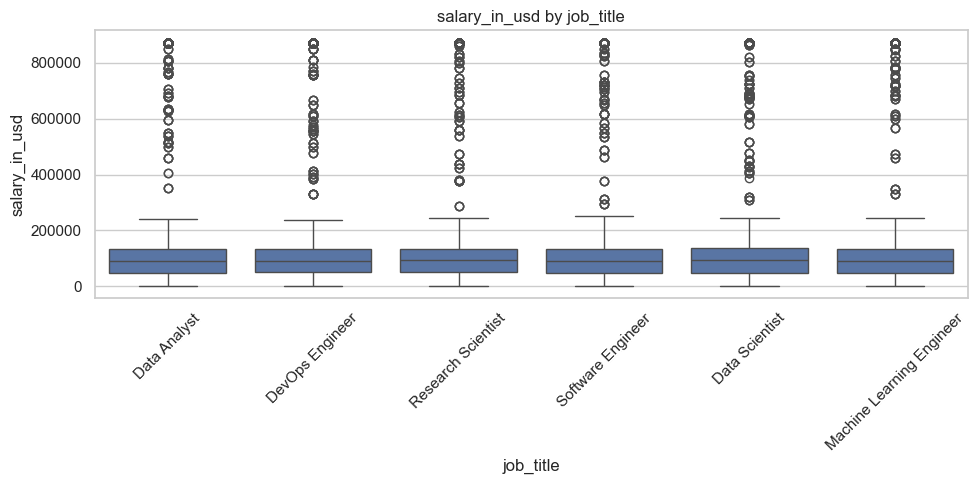

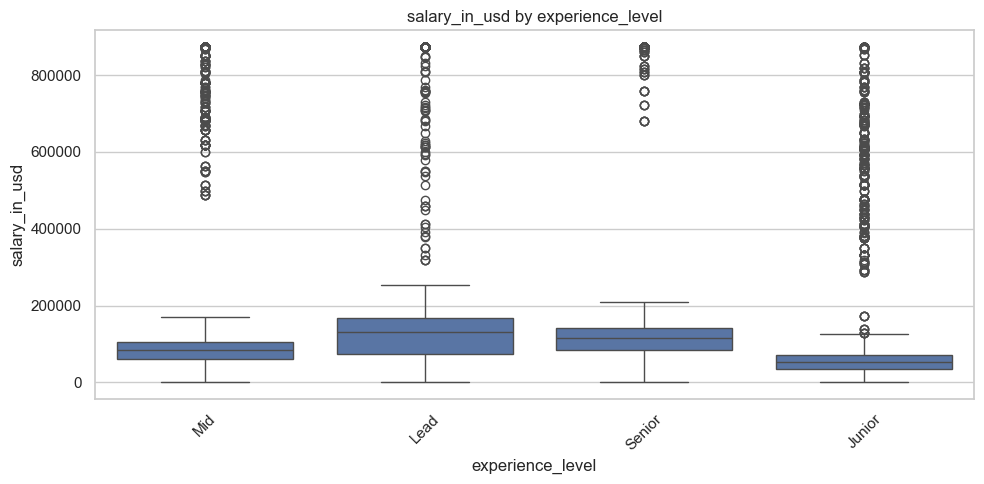

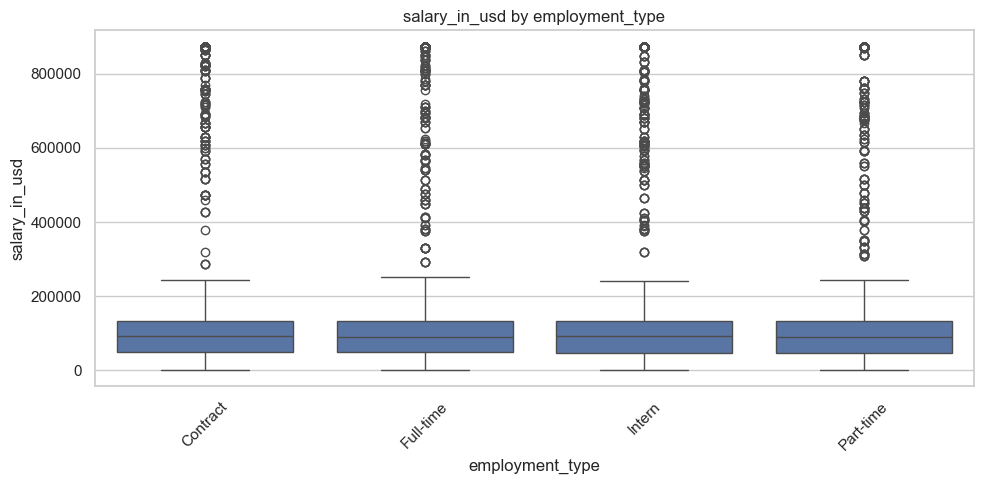

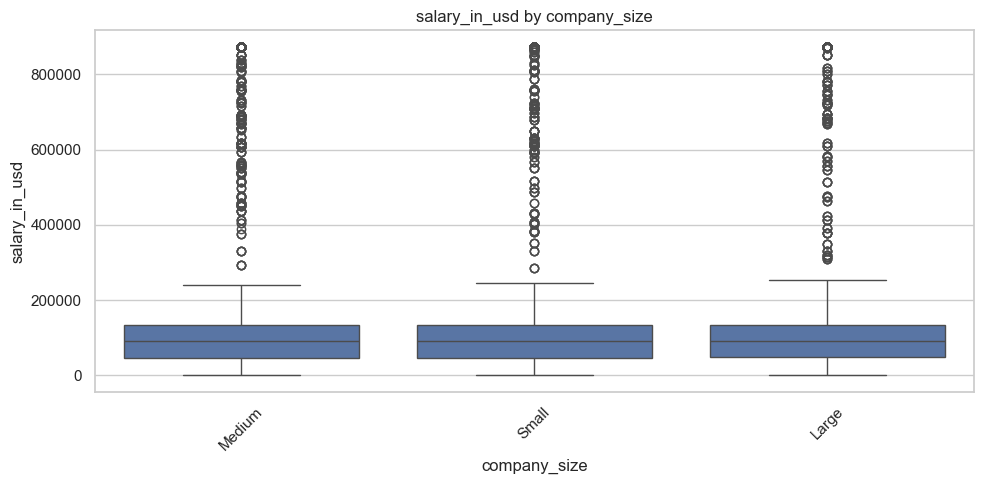

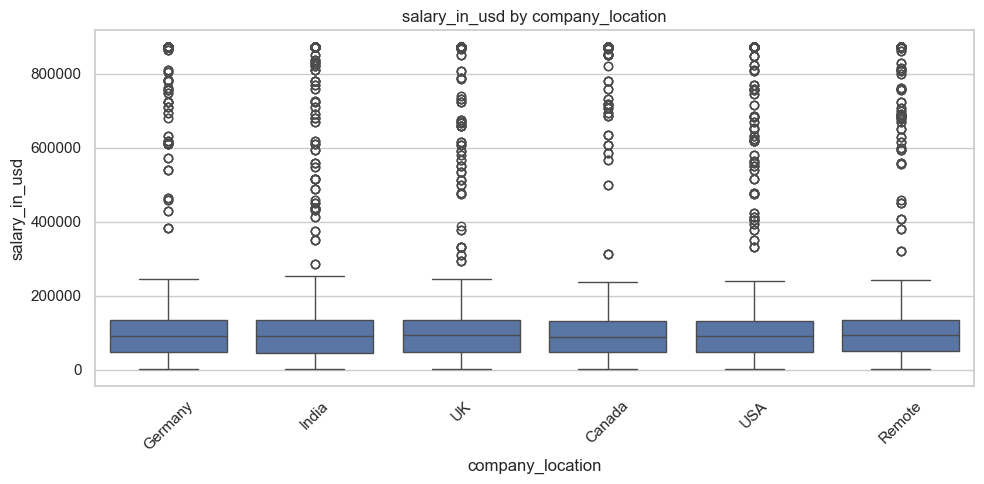

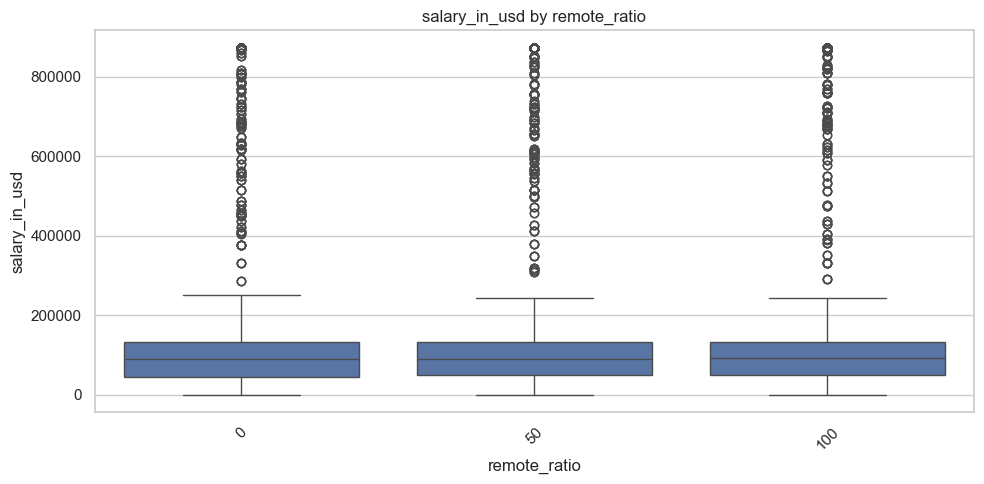

In [127]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'salary_in_usd'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


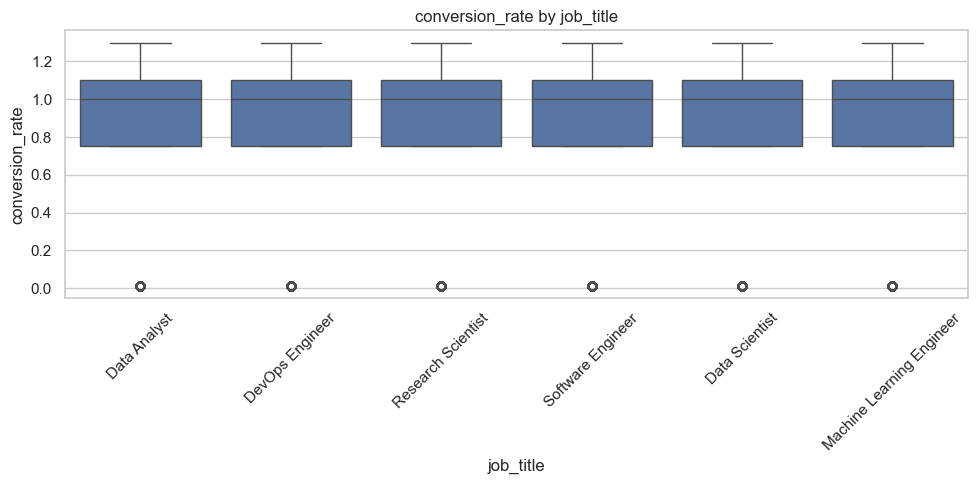

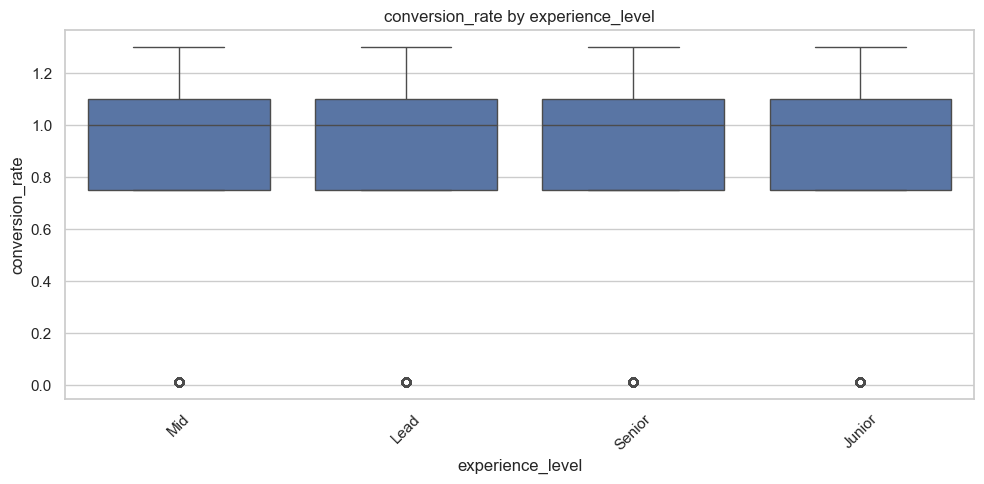

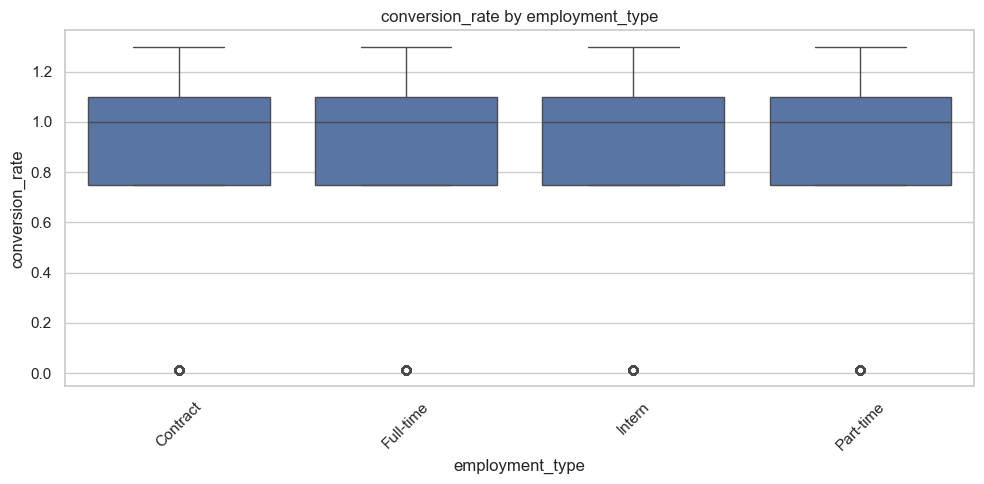

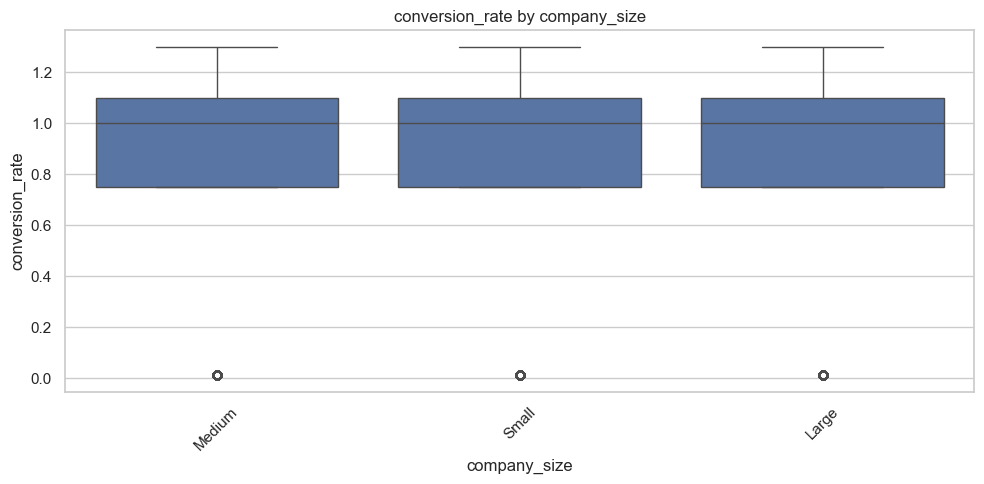

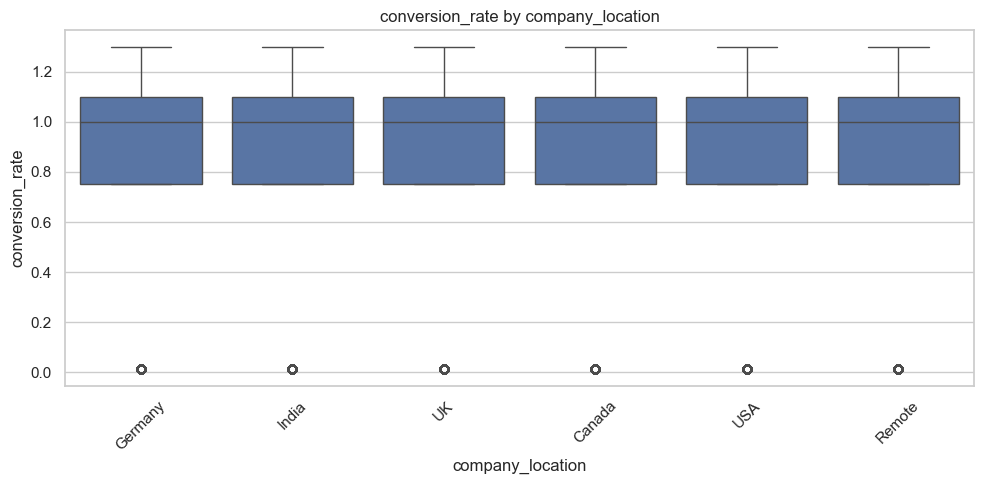

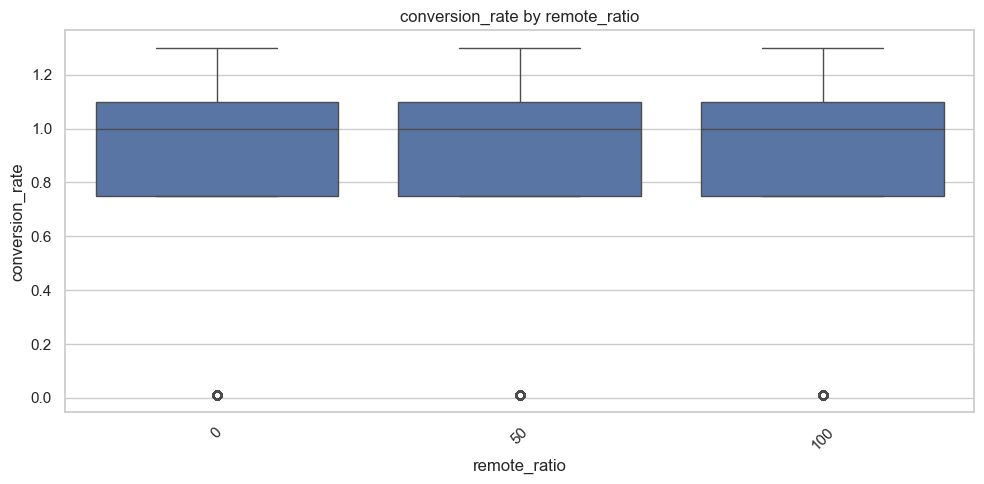

In [128]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'conversion_rate'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


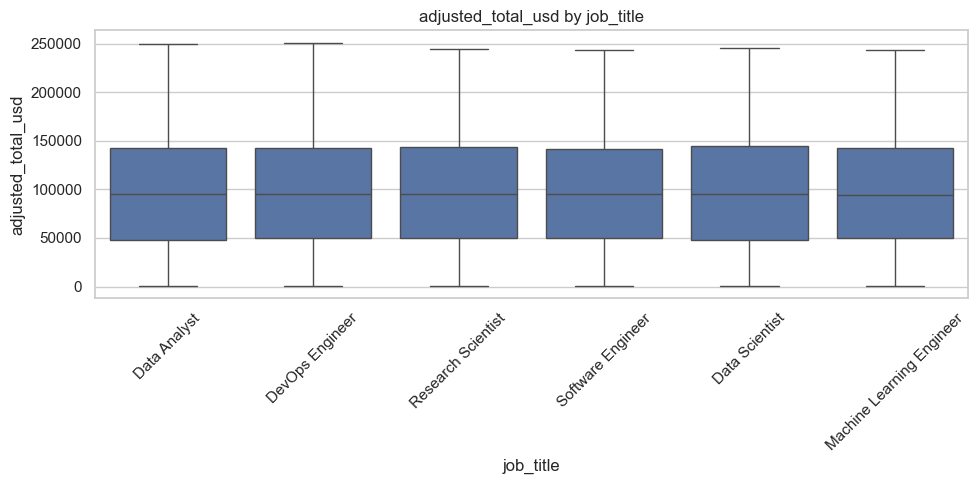

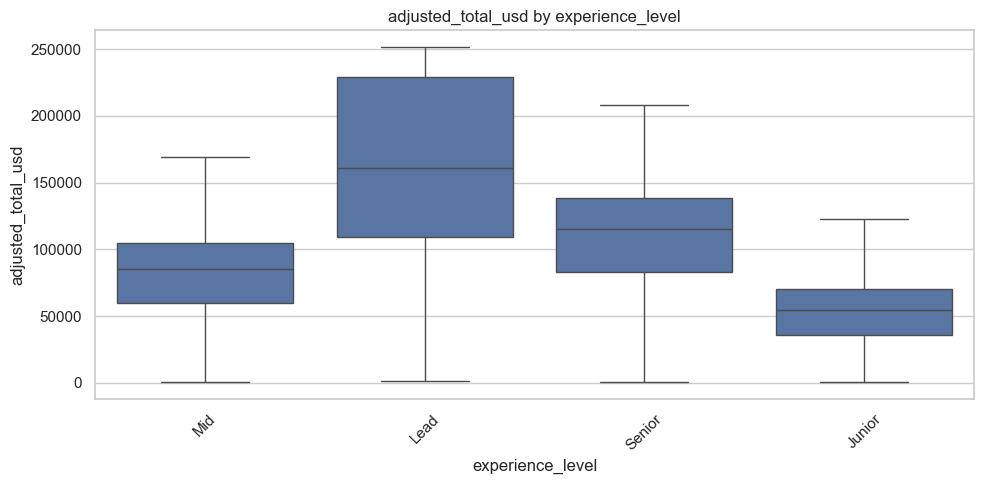

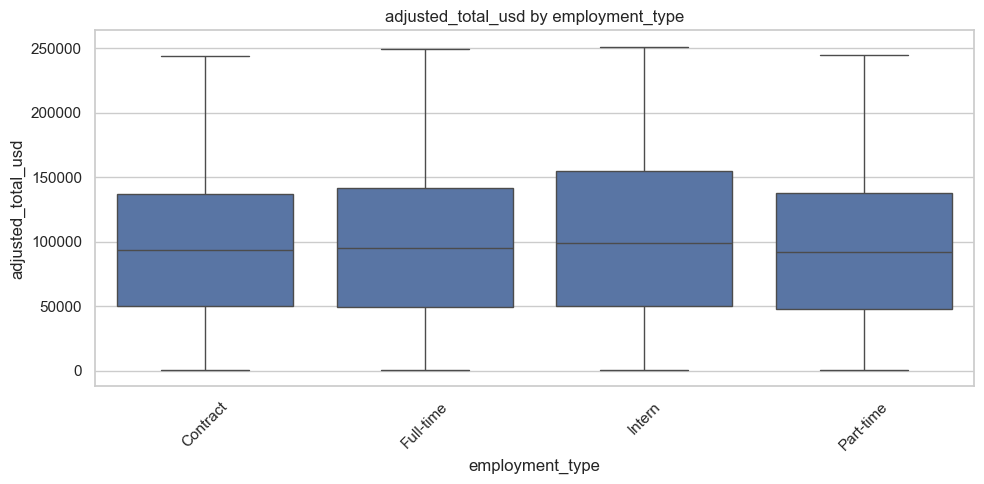

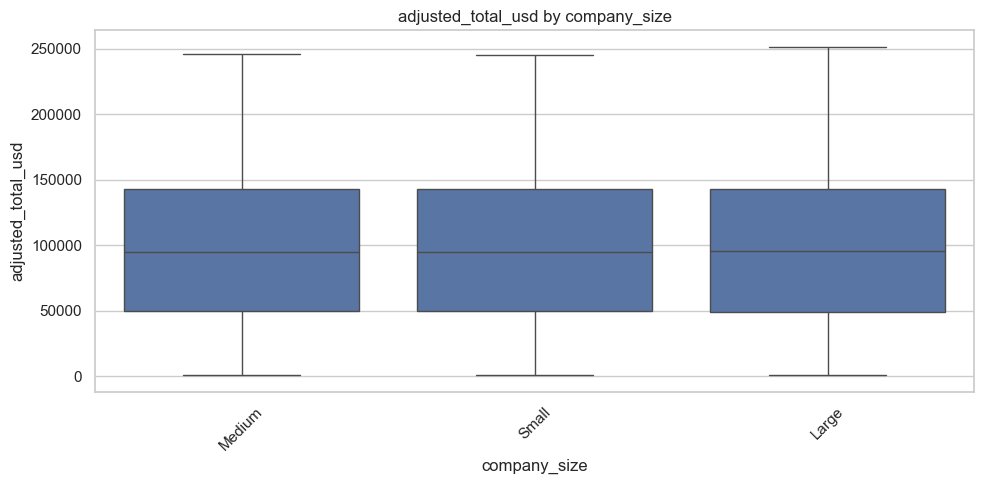

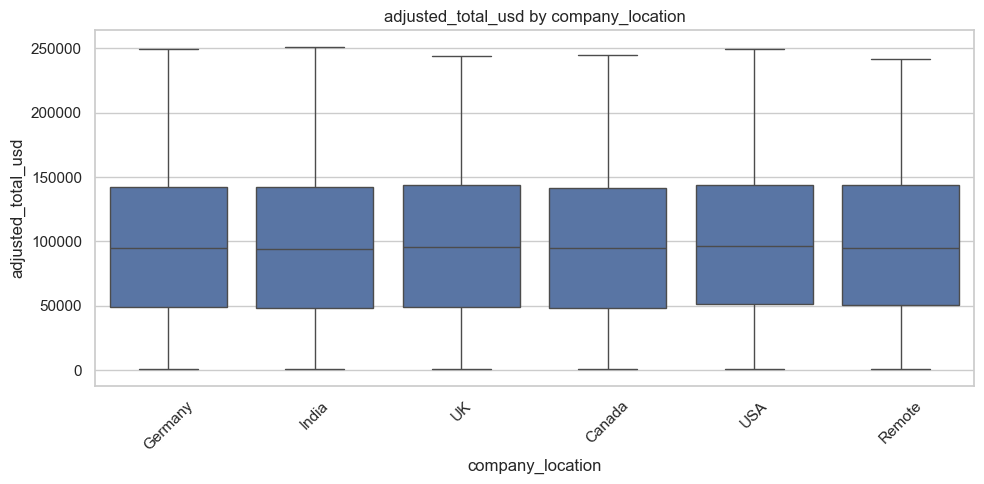

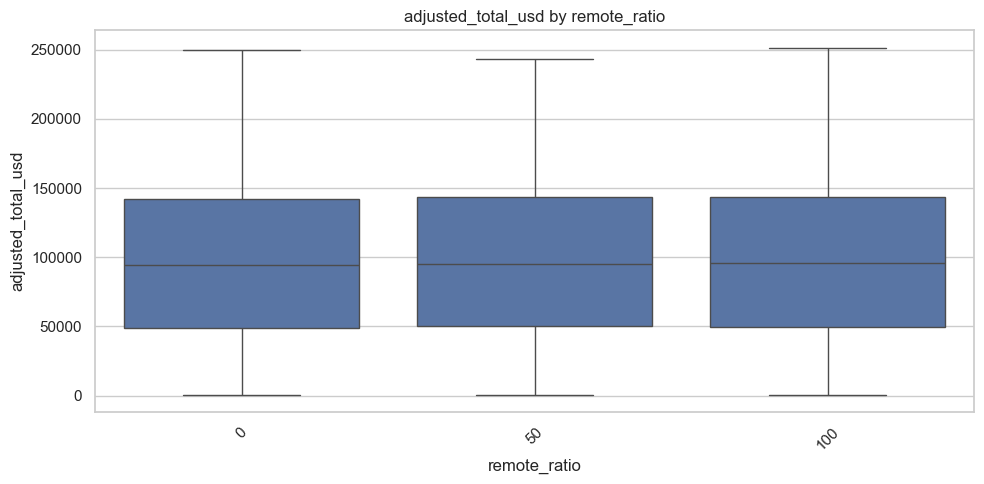

In [130]:
# Step 1: Categorical vs Numerical
import seaborn as sns
import matplotlib.pyplot as plt

target = 'adjusted_total_usd'
cat_features = ['job_title', 'experience_level', 'employment_type', 'company_size', 
                'company_location', 'remote_ratio']

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y=target, showfliers=False)
    plt.xticks(rotation=45)
    plt.title(f'{target} by {col}')
    plt.tight_layout()
    plt.show()


We can cleraly notice outliers in all numerical cols, so we winsorize it, then perform a log tranformation and then using robast scaler to ensure normal distiburation of dataset.

In [152]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler

# Winsorizing (capping outliers at 5th and 95th percentile)
for col in numerical_cols:
    df[col] = mstats.winsorize(df[col], limits=(0.05, 0.05))

# Log transformation (handle zero or negative by shifting)
for col in numerical_cols:
    min_val = df[col].min()
    if min_val <= 0:
        shift = abs(min_val) + 1
        df[col] = np.log1p(df[col] + shift)
    else:
        df[col] = np.log1p(df[col])

# Robust scaling (median and IQR based)
scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# df is now transformed and ready to use
print(df.head())


            job_title experience_level employment_type company_size  \
0        Data Analyst              Mid        Contract       Medium   
1     DevOps Engineer              Mid        Contract        Small   
2  Research Scientist             Lead        Contract       Medium   
3   Software Engineer             Lead       Full-time        Large   
4   Software Engineer             Lead          Intern        Large   

  company_location  remote_ratio salary_currency  years_experience  \
0          Germany             0             INR          0.245876   
1            India           100             GBP         -0.097173   
2          Germany             0             EUR          0.609522   
3            India            50             INR         -0.324678   
4          Germany           100             INR          0.000000   

   base_salary     bonus  ...  salary_in_usd  currency  conversion_rate  \
0    -0.404710 -1.381941  ...      -4.384364       USD         0.000000   
1 

Now we are done with bivariant analysis and handling outliers.

Multivariant analysis

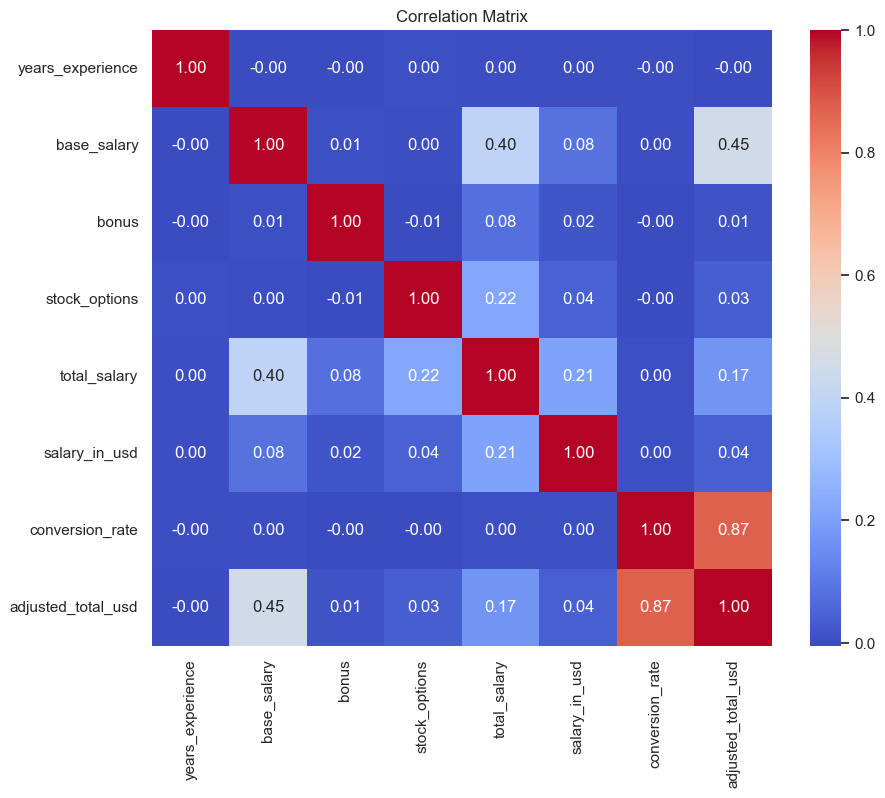

In [153]:
# Coreletion matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and numerical_cols is the list of numerical columns

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [161]:
categorical_cols

['job_title',
 'experience_level',
 'employment_type',
 'company_size',
 'company_location',
 'salary_currency',
 'currency',
 'remote_ratio']

In [162]:
numerical_cols


['years_experience',
 'base_salary',
 'bonus',
 'stock_options',
 'total_salary',
 'salary_in_usd',
 'conversion_rate',
 'adjusted_total_usd']

In [166]:
df_cleaned = df[categorical_cols + numerical_cols].copy()

In [179]:
df['experience_level'].unique()

array(['Mid', 'Lead', 'Senior', 'Junior'], dtype=object)

In [184]:
experience_map = {
    'Junior': 0,
    'Mid': 1,
    'Senior': 2,
    'Lead': 3
}

df['experience_level'] = df['experience_level'].map(experience_map)

In [181]:
# One-hot Encoding for Nominal Categorical Columns

# List of nominal categorical columns
nominal_cols = [
    'job_title',
    'employment_type',
    'company_size',
    'company_location',
    'salary_currency',
    'currency'
]

# Get dummies (drop_first=True to avoid dummy variable trap)
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   experience_level                     100000 non-null  int64  
 1   remote_ratio                         100000 non-null  int64  
 2   years_experience                     100000 non-null  float64
 3   base_salary                          100000 non-null  float64
 4   bonus                                100000 non-null  float64
 5   stock_options                        100000 non-null  float64
 6   total_salary                         100000 non-null  float64
 7   salary_in_usd                        100000 non-null  float64
 8   conversion_rate                      100000 non-null  float64
 9   adjusted_total_usd                   100000 non-null  float64
 10  experience_level_encoded             100000 non-null  int64  
 11  job_title_Data


Silhouette Score for k=2: 0.0743


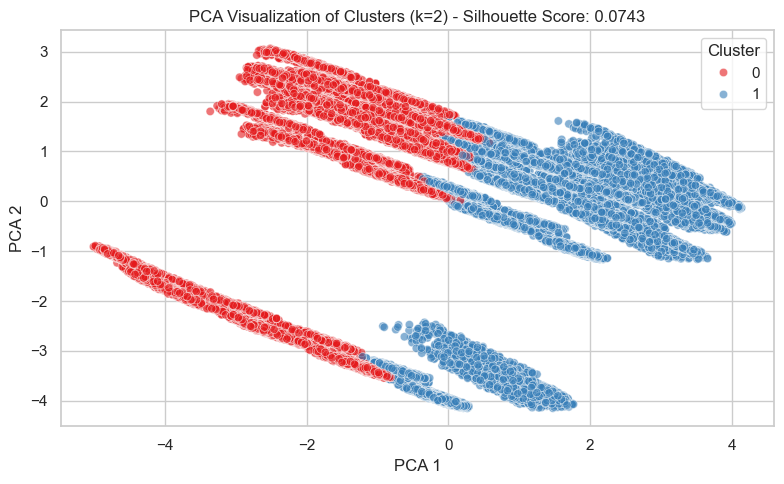

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set your desired number of clusters
k = 2  # You can change this to any value you want

# ---------- Prepare the data ----------
# 'df' should be your final preprocessed (numerical + encoded) DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# ---------- Apply KMeans ----------
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# ---------- Evaluate ----------
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"\nSilhouette Score for k={k}: {sil_score:.4f}")

# ---------- PCA for visualization ----------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_vis = df.copy()
df_vis['cluster'] = cluster_labels
df_vis['pca_1'] = pca_result[:, 0]
df_vis['pca_2'] = pca_result[:, 1]

# ---------- Plot ----------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_vis, x='pca_1', y='pca_2', hue='cluster', palette='Set1', alpha=0.6)
plt.title(f'PCA Visualization of Clusters (k={k}) - Silhouette Score: {sil_score:.4f}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


No good clustering is there

In [190]:
# Get correlation of all numerical columns with the target
target_col = 'adjusted_total_usd'  # or use 'total_salary' if you prefer
correlations = df.corr()[target_col].drop(target_col)

# Sort by absolute correlation
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Display top 15 features (change as needed)
print(correlations_sorted.head(15))


currency_INR                 0.886443
conversion_rate              0.870724
base_salary                  0.451153
experience_level             0.312801
experience_level_encoded     0.312801
currency_GBP                 0.281045
currency_EUR                 0.237587
currency_USD                 0.219565
total_salary                 0.168379
employment_type_Intern       0.055849
salary_in_usd                0.038575
stock_options                0.034834
employment_type_Part-time    0.031188
bonus                        0.012332
salary_currency_USD          0.008500
Name: adjusted_total_usd, dtype: float64


In [192]:
# Select features with absolute correlation > 0.1
selected_features = correlations_sorted[correlations_sorted > 0.1].index.tolist()

# Final features to keep
features_to_keep = selected_features + [target_col]

# Keep only the important features in the DataFrame
df_reduced = df[features_to_keep].copy()


In [193]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   currency_INR              100000 non-null  bool   
 1   conversion_rate           100000 non-null  float64
 2   base_salary               100000 non-null  float64
 3   experience_level          100000 non-null  int64  
 4   experience_level_encoded  100000 non-null  int64  
 5   currency_GBP              100000 non-null  bool   
 6   currency_EUR              100000 non-null  bool   
 7   currency_USD              100000 non-null  bool   
 8   total_salary              100000 non-null  float64
 9   adjusted_total_usd        100000 non-null  float64
dtypes: bool(4), float64(4), int64(2)
memory usage: 5.0 MB


In [196]:
# Save the DataFrame to CSV in the current working directory
df.to_csv("adjusted_salary_model_data.csv", index=False)



Silhouette Score for k=2: 0.2567


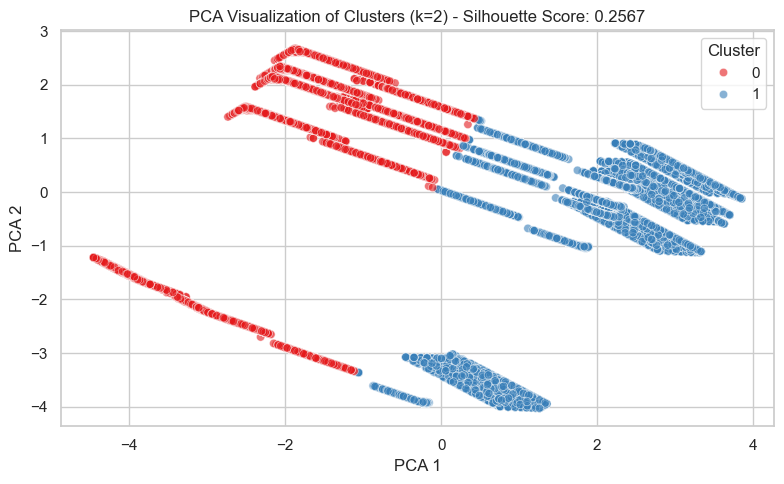

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set your desired number of clusters
k = 2  # You can change this to any value you want

# ---------- Prepare the data ----------
# 'df' should be your final preprocessed (numerical + encoded) DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reduced)

# ---------- Apply KMeans ----------
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# ---------- Evaluate ----------
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"\nSilhouette Score for k={k}: {sil_score:.4f}")

# ---------- PCA for visualization ----------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_vis = df.copy()
df_vis['cluster'] = cluster_labels
df_vis['pca_1'] = pca_result[:, 0]
df_vis['pca_2'] = pca_result[:, 1]

# ---------- Plot ----------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_vis, x='pca_1', y='pca_2', hue='cluster', palette='Set1', alpha=0.6)
plt.title(f'PCA Visualization of Clusters (k={k}) - Silhouette Score: {sil_score:.4f}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
